This notebook shows how to use `ShapExplainer` class of AI4Water. The `ShapExplainer` class is a wrapper around [SHAP](https://github.com/slundberg/shap) library. It helps in making different plots for local as well as global explainations of model 

In [1]:
try:
    import AI4Water
except ImportError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.__version__

'1.19.5'

In [3]:
np.random.seed(313)

In [4]:
import pandas as pd
pd.__version__

'1.2.0'

In [5]:
from ai4water import Model
from ai4water.datasets import MtropicsLaos
from ai4water.post_processing.explain import ShapExplainer
from ai4water.post_processing.explain import explain_model_with_shap
from ai4water.utils.visualizations import regplot
from ai4water.post_processing.SeqMetrics import RegressionMetrics

In [6]:
laos = MtropicsLaos()
data = laos.make_regression()


Not downloading the data since the directory 
D:\mytools\AI4Water\ai4water\datasets\data\MtropicsLaos already exists.
Use overwrite=True to remove previously saved files and download again


preprocessing of shapefiles can not be done because no fiona installation is found.
Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


In [7]:
data.shape

(650741, 8)

In [8]:
data.isna().sum()

temp                 0
rel_hum              0
wind_speed           0
sol_rad              0
water_level          0
pcp                  0
susp_pm              0
Ecoli_mpn100    650483
dtype: int64

In [9]:
data.dropna()

temp  rel_hum  wind_speed   sol_rad  water_level  pcp  \
2011-05-25 16:36:00  22.90   100.00      2.2000   34.8000   144.600000  0.0   
2011-05-25 17:06:00  22.90   100.00      2.9000    6.0000   147.800000  0.0   
2011-05-25 17:24:00  22.90   100.00      2.6000    6.0000   149.100000  0.0   
2011-05-25 17:42:00  22.90   100.00      2.3000    6.0000   151.800000  0.0   
2011-05-25 18:06:00  22.90   100.00      1.9000    5.8000   149.300000  0.0   
...                    ...      ...         ...       ...          ...  ...   
2018-09-09 14:24:00  31.76    65.76      0.8172  245.0016   142.307339  0.0   
2018-09-19 15:24:00  30.66    76.32      0.2442  140.0472   143.900000  0.0   
2018-09-29 17:12:00  28.84    80.28      0.1376   19.6872   140.094382  0.0   
2018-10-09 14:12:00  32.96    57.96      0.2842  221.8536   138.405556  0.0   
2018-10-19 14:30:00  33.95    60.85      0.2170  199.1520   137.200000  0.0   

                      susp_pm  Ecoli_mpn100  
2011-05-25 16:36:00  0.900000        1100.0  
2011-05-25 17:06:00  0.990000        1400.0  
2011-05-25 17:24:00  1.330000       14000.0  
2011-05-25 17:42:00  0.960000        1300.0  
2011-05-25 18:06:00  0.740000       29000.0  
...                       ...           ...  
2018-09-09 14:24:00  0.536700        3100.0  
2018-09-19 15:24:00  2.998118           0.0  
2018-09-29 17:12:00  2.048727         250.0  
2018-10-09 14:12:00  1.118183         200.0  
2018-10-19 14:30:00  0.502894         120.0  

[258 rows x 8 columns]

<AxesSubplot:>

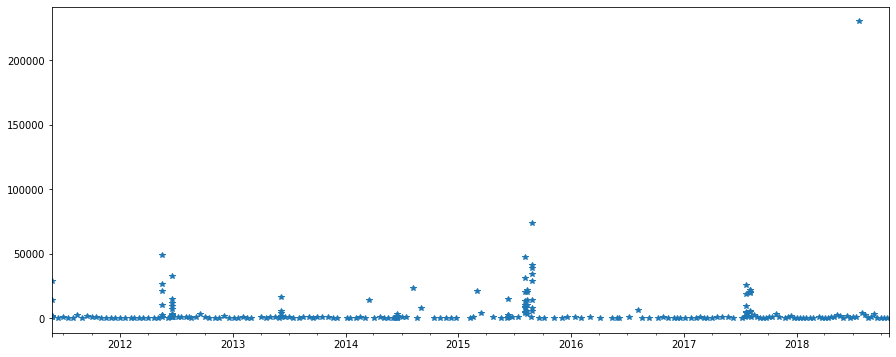

In [10]:
plt.close('all')
data['Ecoli_mpn100'].plot(style="*", figsize=(15, 6))

There is a very high observation in 2018 which looks like an outlier.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

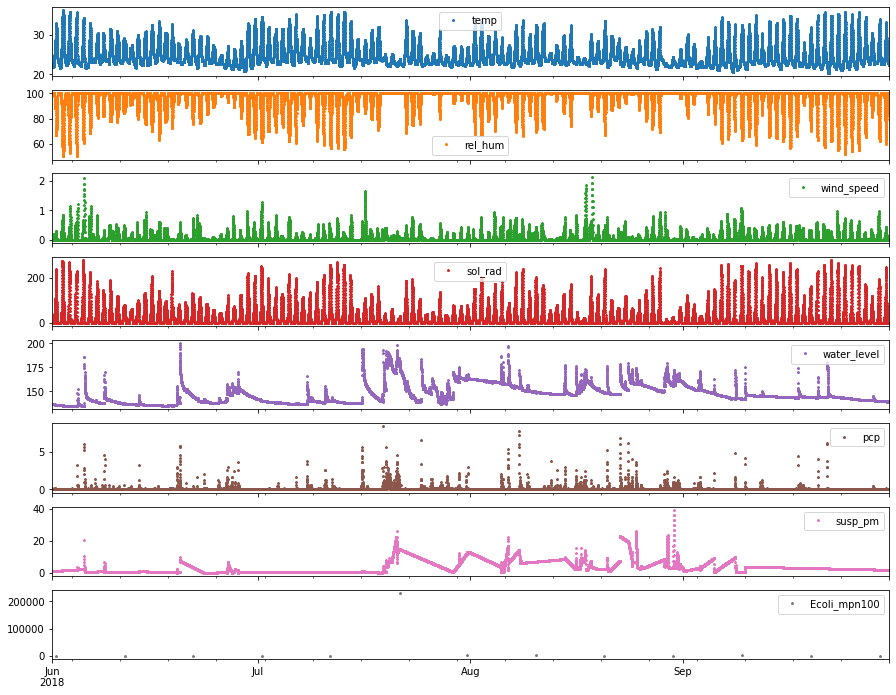

In [11]:
data.loc["20180601":"20180930"].plot(style="*", subplots=True, figsize=(15, 12), ms=2.5)

Zooming in shows that the extremely high E. coli value was recorded in mid July which conincided with high water level, suspended solids and oviosly precipitation. It should be noted that the temperature, relative humidity, wind speed and solar radiation do not show any anomalous pattern in this period.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

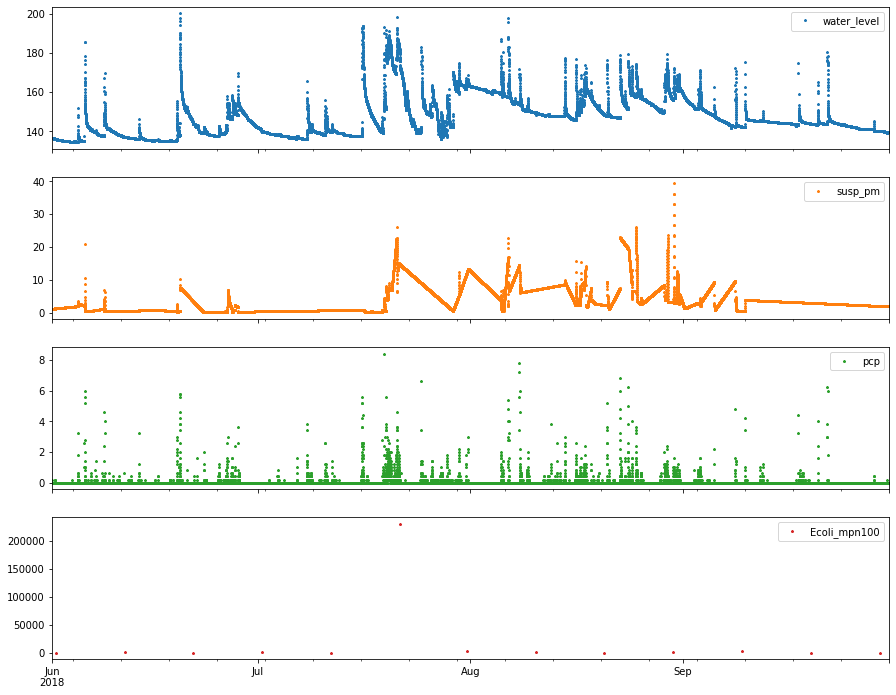

In [12]:
data[["water_level", "susp_pm", "pcp", "Ecoli_mpn100"]].loc["20180601":"20180930"].plot(style="*",
                                                                                        subplots=True,
                                                                                        figsize=(15, 12),
                                                                                        ms=2.5)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

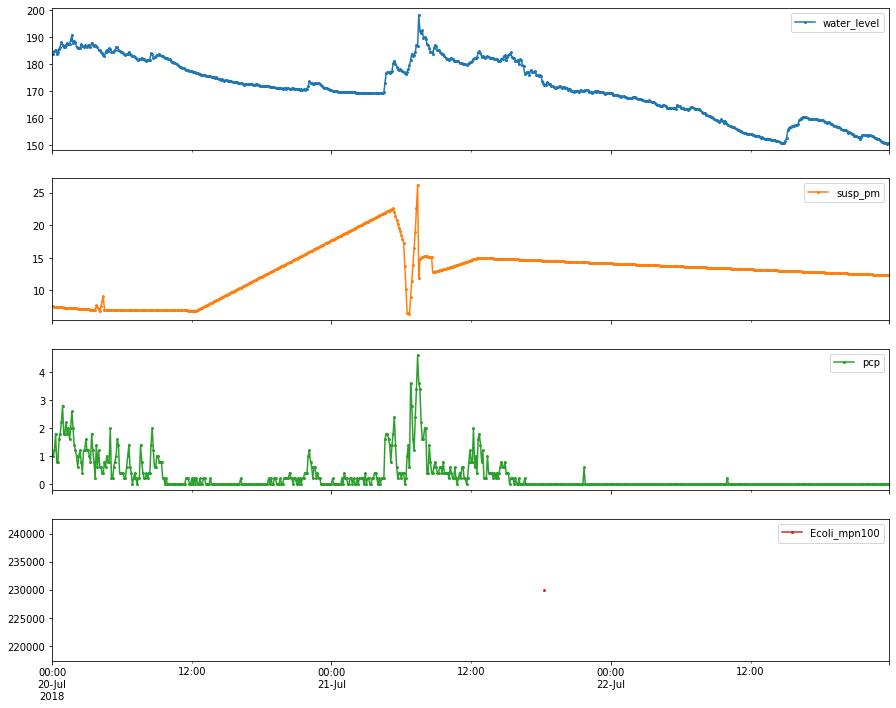

In [13]:
data[["water_level", "susp_pm", "pcp", "Ecoli_mpn100"]].loc["20180720":"20180722"].plot(style="-*",
                                                                                        subplots=True,
                                                                                        figsize=(15, 12),
                                                                                        ms=2.5)

There is significant rainfall just before the E. coli was recorded. However when the E. coli was recorded, the rainfall had stopped.

#### 2017
In 2017 we have 2 flood events in late July and early August

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

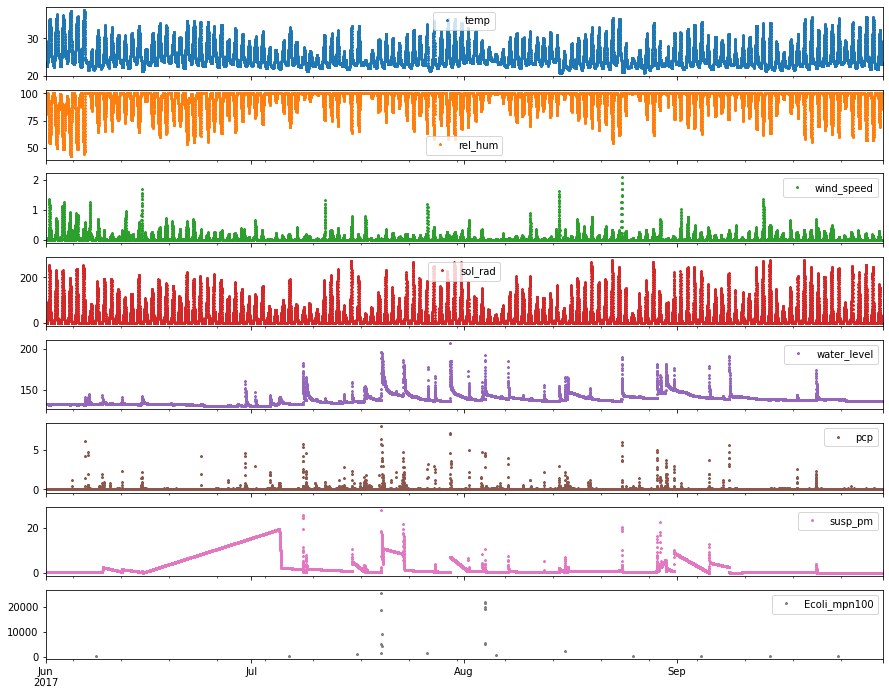

In [14]:
data.loc["20170601":"20170930"].plot(style="*", subplots=True, figsize=(15, 12), ms=2.5)

#### 2015

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

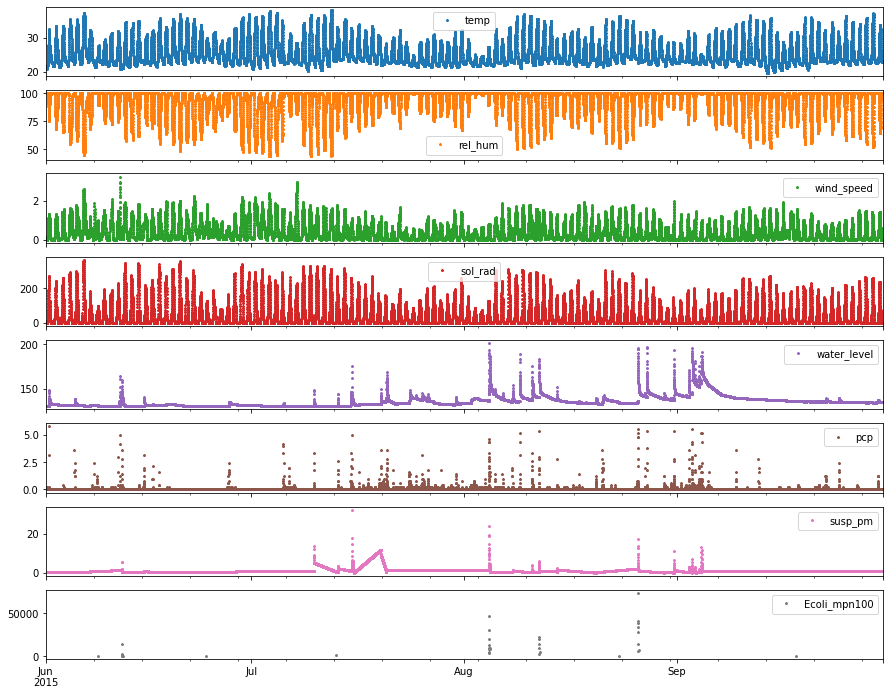

In [15]:
data.loc["20150601":"20150930"].plot(style="*", subplots=True, figsize=(15, 12), ms=2.5)

Three flood events are recorded in August 2015.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

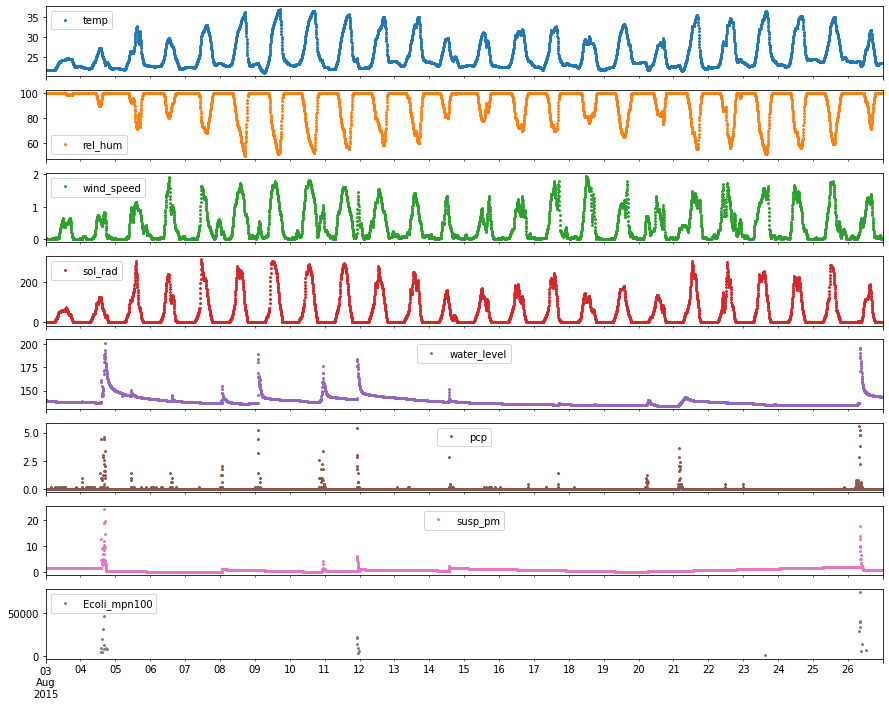

In [16]:
data.loc["20150803":"20150826"].plot(style="*", subplots=True, figsize=(15, 12), ms=2.5)

In [17]:
model = Model(model="XGBoostRegressor",
              prefix="ecoli_shap",  # folder name to save results
              val_fraction=0.0,
             data=data)

building ML model for  regression problem using XGBoostRegressor


In [18]:
model.fit()


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (206, 7)
target shape:  (206, 1, 1)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Prediction on test data


********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (52, 7)
target shape:  (52, 1, 1)


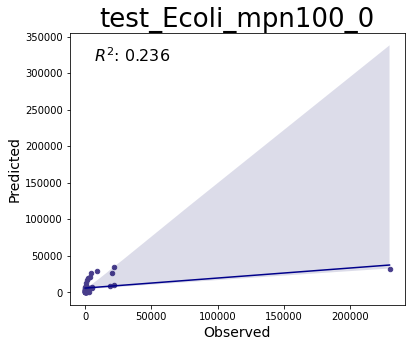

divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log


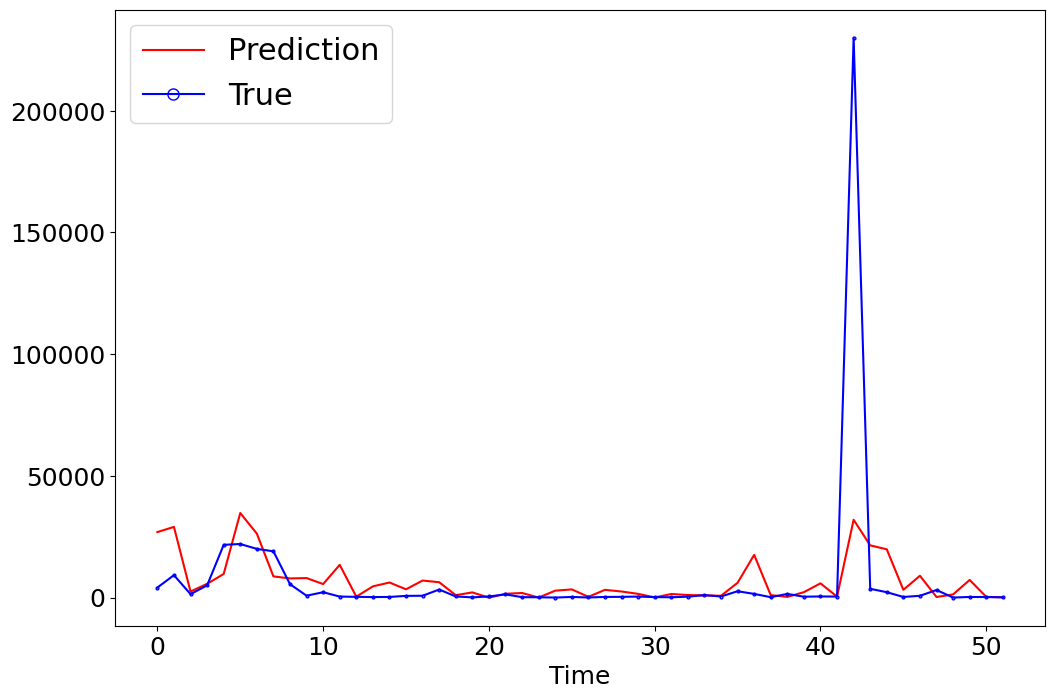

In [19]:
y_true, y_pred = model.predict(return_true=True)

In [20]:
for idx,t,p in zip(range(len(y_true)), y_true, y_pred):
    print(idx, t, p)

0 [[4100.]] 26905.023
1 [[9200.]] 29029.021
2 [[1400.]] 2469.3303
3 [[5000.]] 5640.546
4 [[21666.66666667]] 9696.198
5 [[22000.]] 34729.65
6 [[20000.]] 26273.096
7 [[19000.]] 8699.292
8 [[5500.]] 7859.3813
9 [[760.]] 8004.3447
10 [[2200.]] 5544.8193
11 [[400.]] 13440.901
12 [[300.]] 361.81683
13 [[200.]] 4597.04
14 [[250.]] 6179.1763
15 [[690.]] 3394.9224
16 [[740.]] 6991.38
17 [[3300.]] 6297.485
18 [[450.]] 985.02295
19 [[78.]] 2118.0894
20 [[450.]] -66.8688
21 [[1300.]] 1553.7823
22 [[160.]] 1872.9869
23 [[120.]] -4.3455806
24 [[0.]] 2834.7024
25 [[250.]] 3344.1562
26 [[38.]] 301.39252
27 [[250.]] 3170.8042
28 [[300.]] 2490.0803
29 [[400.]] 1519.3002
30 [[200.]] 42.762062
31 [[120.]] 1459.087
32 [[350.]] 1043.5945
33 [[1000.]] 901.5289
34 [[430.]] 730.24457
35 [[2600.]] 6063.8296
36 [[1500.]] 17536.299
37 [[160.]] 986.6712
38 [[1500.]] 278.49863
39 [[340.]] 2215.783
40 [[460.]] 5837.2515
41 [[400.]] 398.87845
42 [[230000.]] 31955.668
43 [[3600.]] 21440.95
44 [[2200.]] 19820.164
45 [[

The prediction performance is low because the model could not predict the outlier value. If we exclude that value, the r2 value improves significantly.

<AxesSubplot:xlabel='Observed', ylabel='Predicted'>

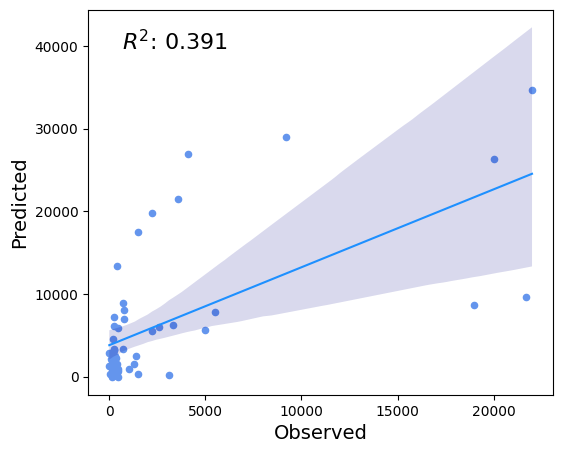

In [21]:
r2 = RegressionMetrics(np.delete(y_true, 42), np.delete(y_pred, 42)).r2()
regplot(np.delete(y_true, 42), np.delete(y_pred, 42), annotation_key="$R^2$", annotation_val=r2)

Prediction on training data


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (206, 7)
target shape:  (206, 1, 1)


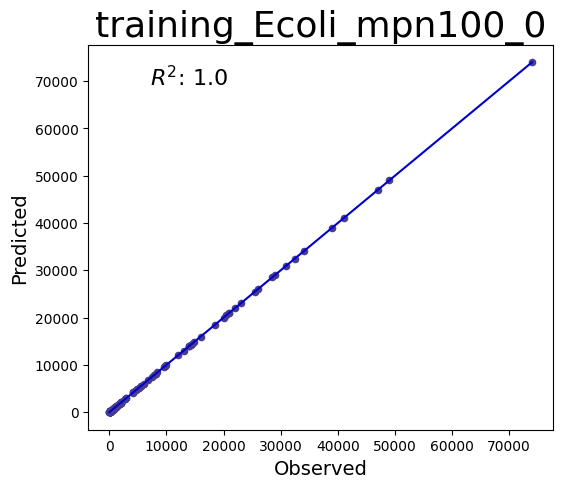

divide by zero encountered in true_divide
divide by zero encountered in log


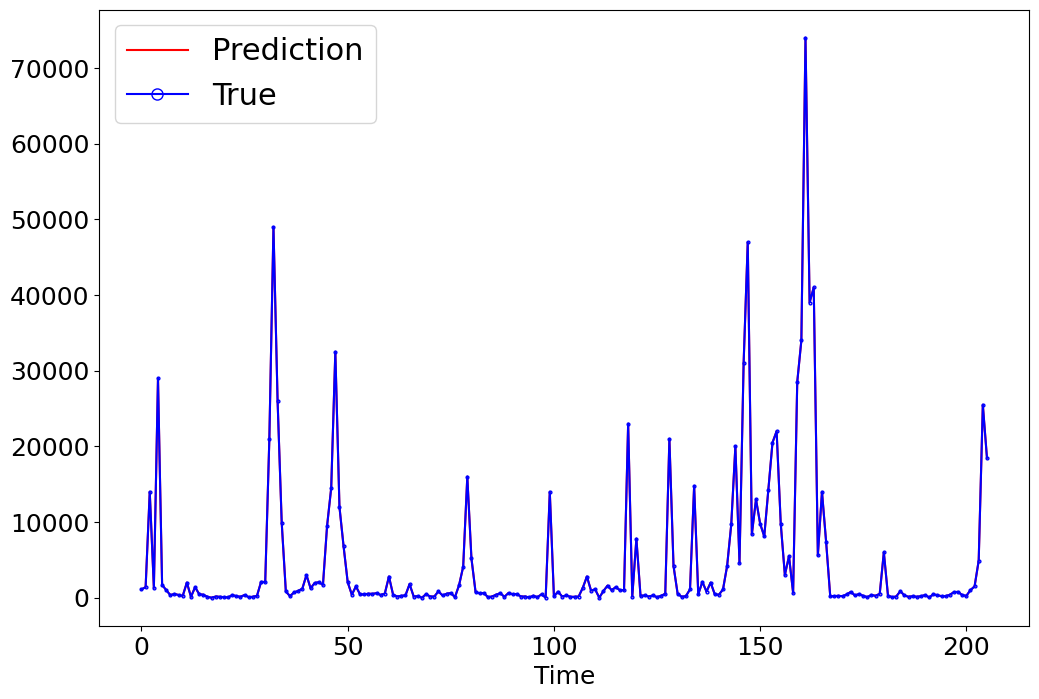

In [22]:
train_y_true, train_y_pred = model.predict(data='training', return_true=True)

In [23]:
train_x, train_y = model.training_data()


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (206, 7)
target shape:  (206, 1, 1)


In [24]:
test_x, test_y = model.test_data()


********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (52, 7)
target shape:  (52, 1, 1)


## default feature importance of xgboost

In [25]:
from ai4water.post_processing.interpret import Interpret

In [26]:
interpreter = Interpret(model=model)

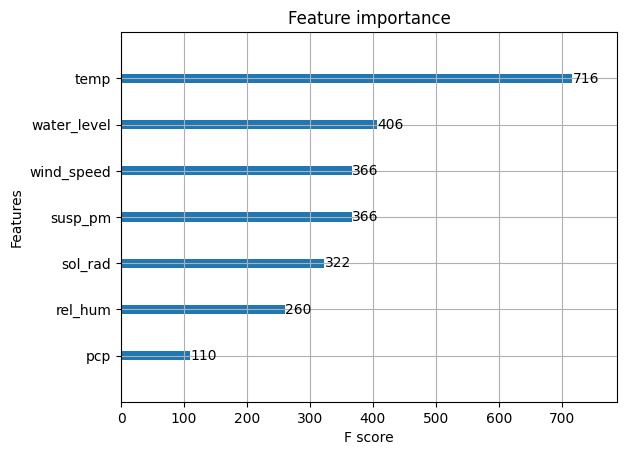

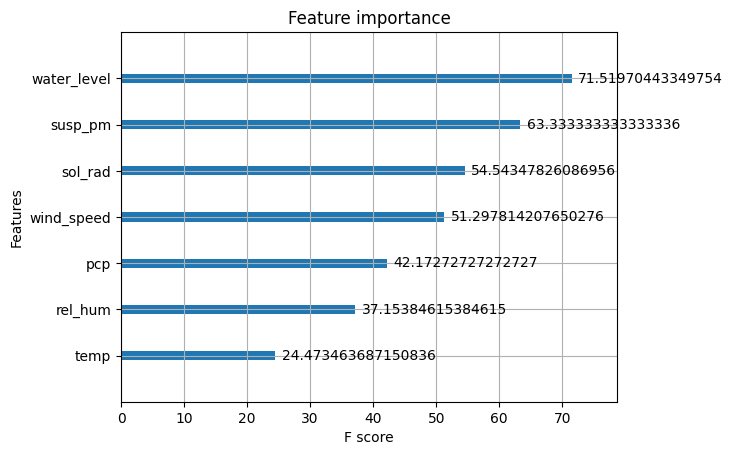

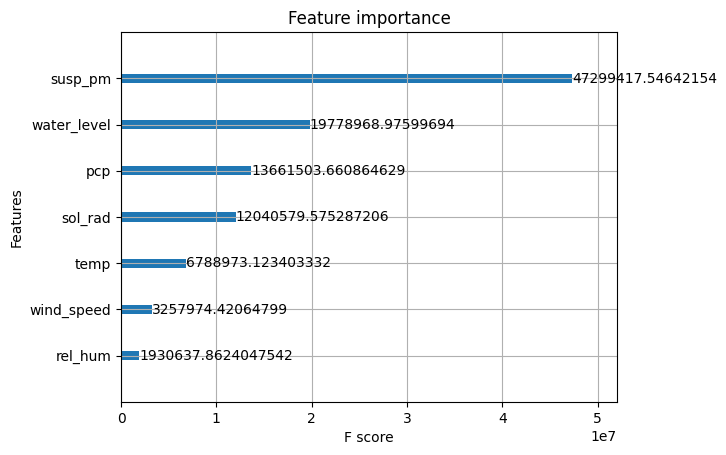

In [27]:
interpreter.plot_feature_importance(show=True, use_xgb=True)

# Explaining using Test data

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

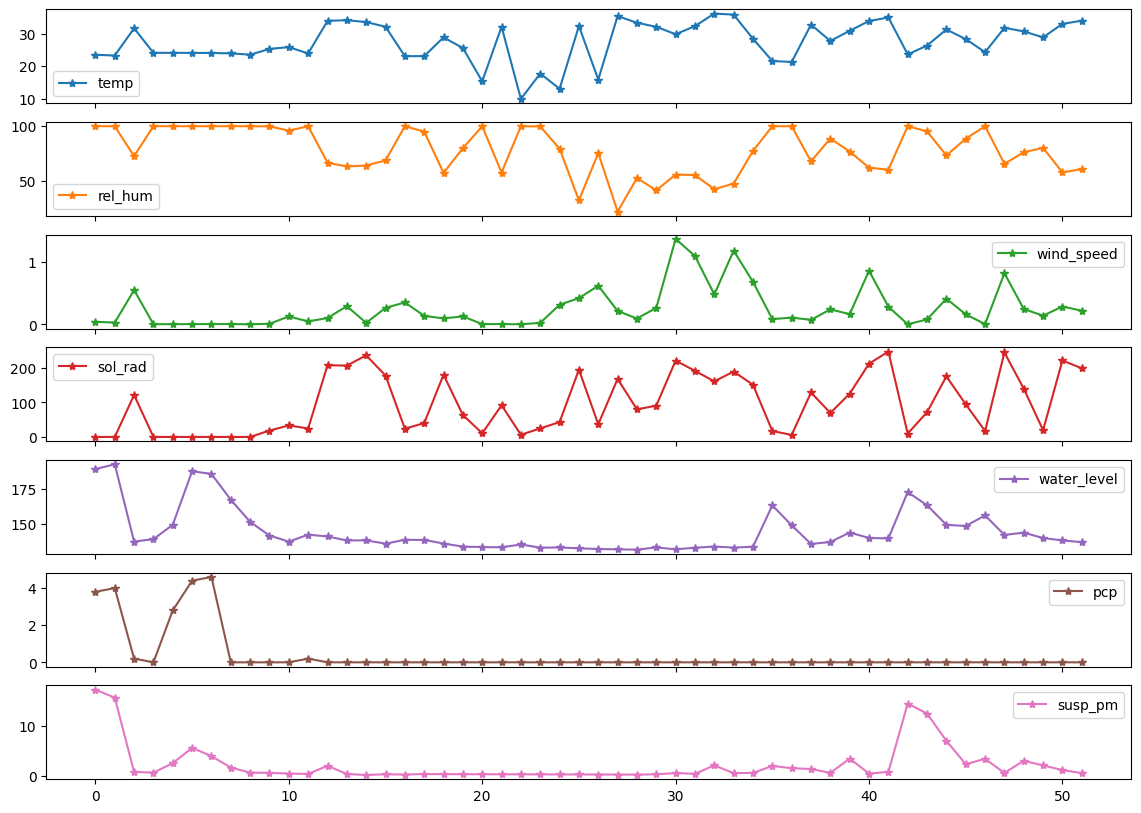

In [28]:
pd.DataFrame(test_x, columns=model.config['input_features']).plot(subplots=True, 
                                                                  figsize=(14, 10),
                                                                 style="-*")

In [29]:
explainer = ShapExplainer(model._model,
                          test_x,
                          train_data=train_x, # the data on which model was trained
                          path=model.path,
                          features=model.dh.input_features, # names of features
                          num_means=10,
                          explainer="TreeExplainer"
                         )

## Partial dependence plots

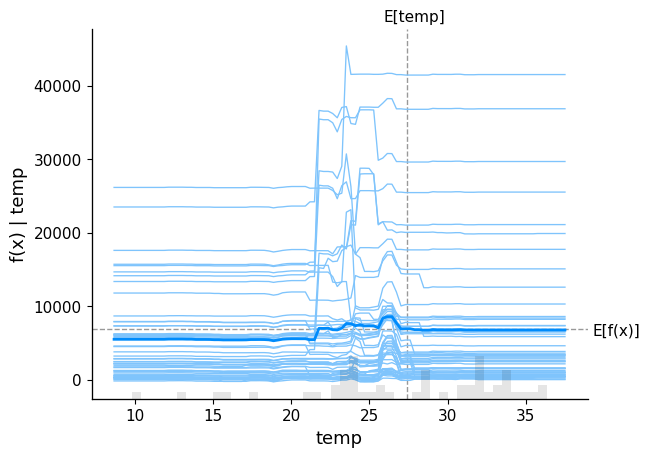

<Figure size 640x480 with 0 Axes>

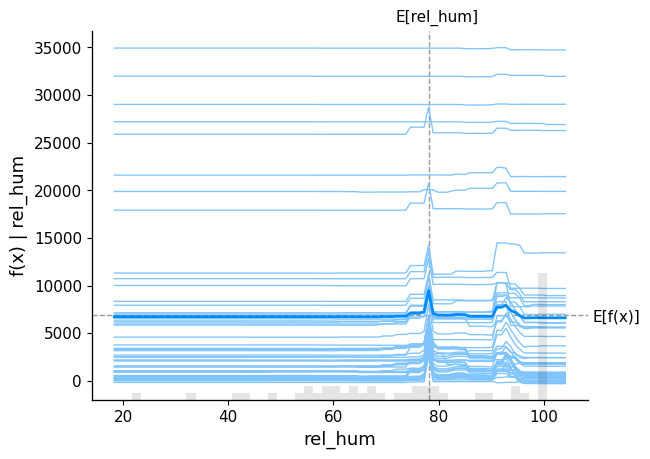

<Figure size 640x480 with 0 Axes>

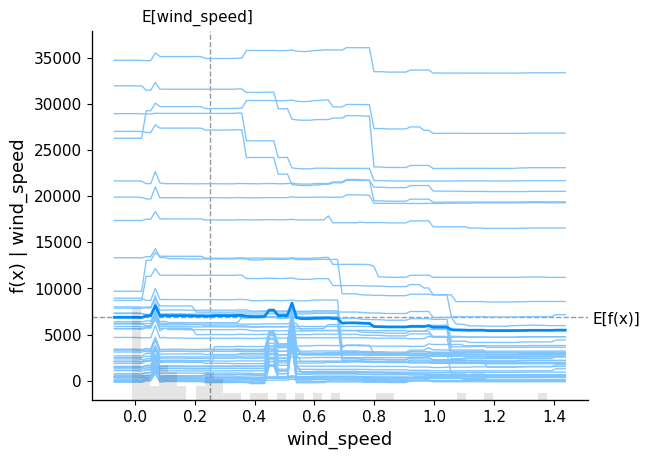

<Figure size 640x480 with 0 Axes>

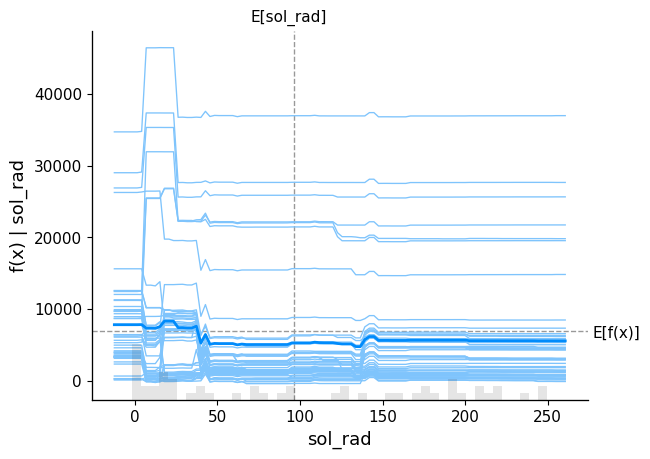

<Figure size 640x480 with 0 Axes>

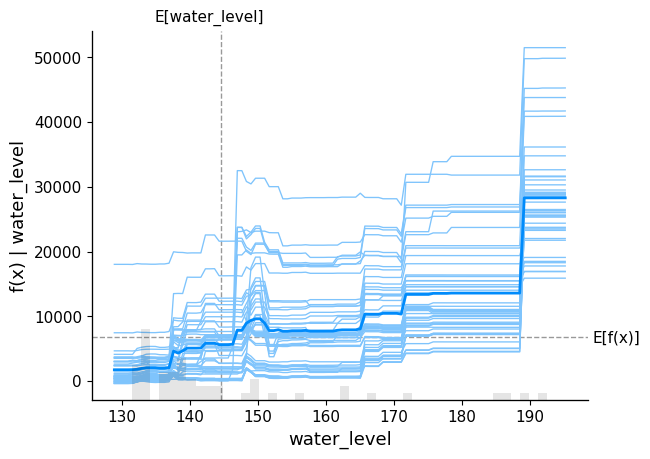

<Figure size 640x480 with 0 Axes>

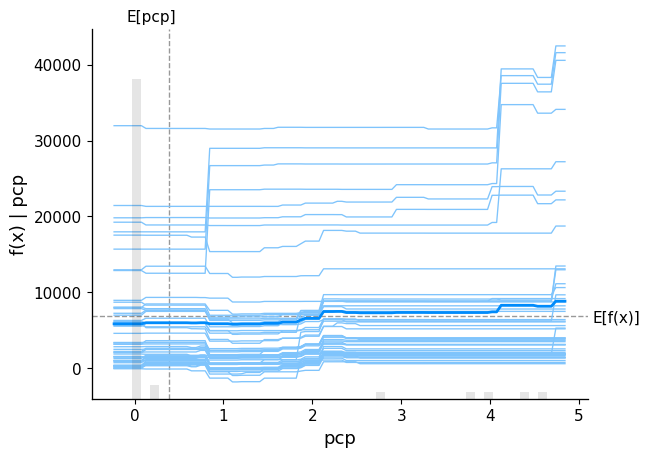

<Figure size 640x480 with 0 Axes>

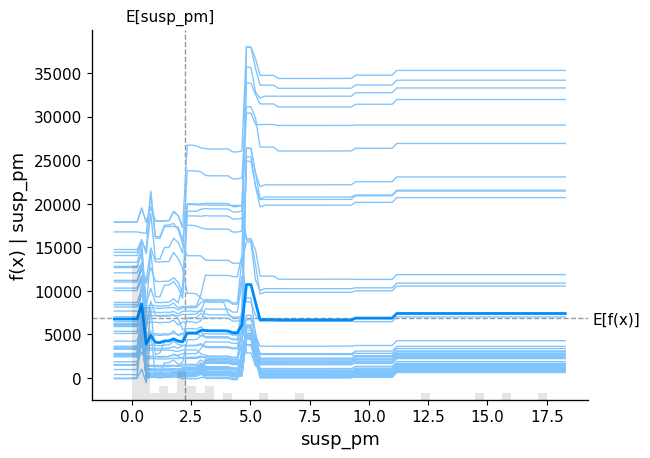

<Figure size 640x480 with 0 Axes>

In [30]:
explainer.pdp_all_features(show=True)

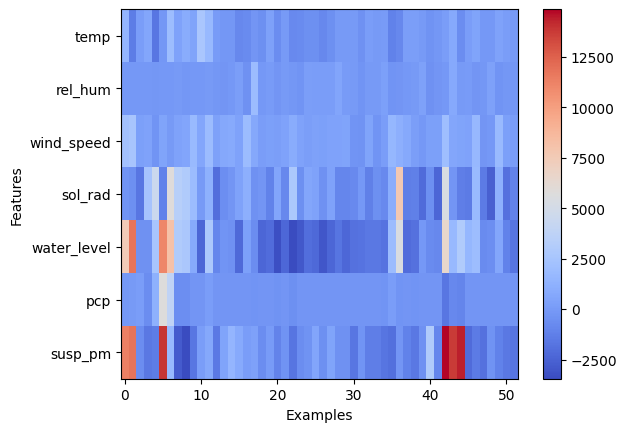

In [31]:
explainer.plot_shap_values()

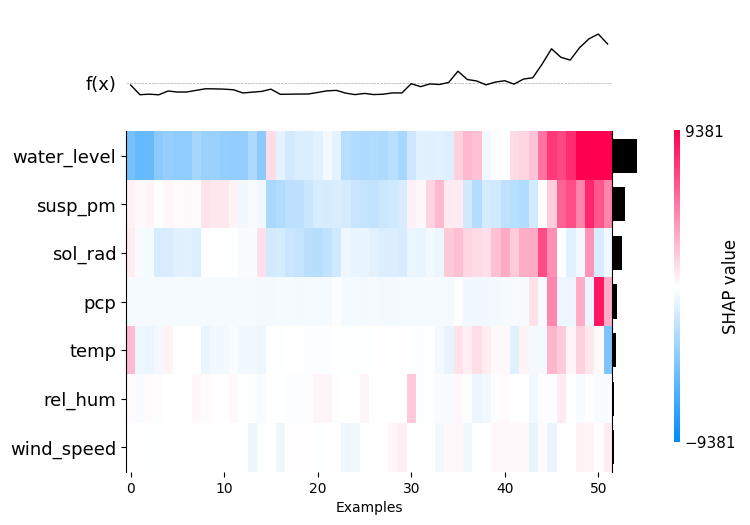

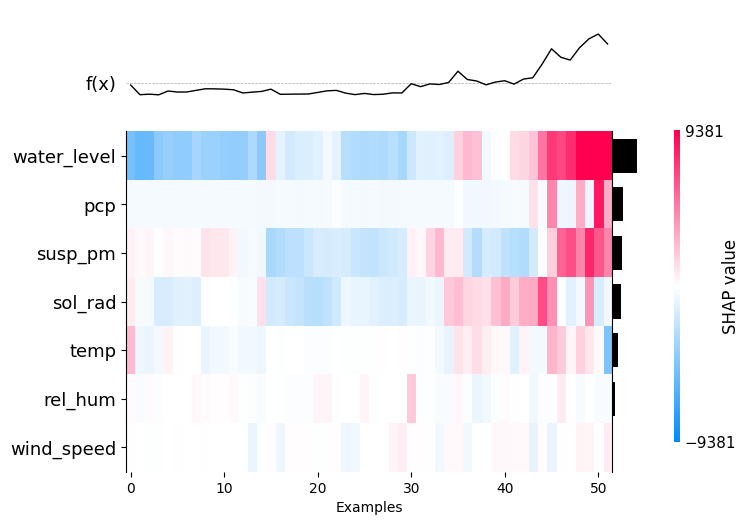

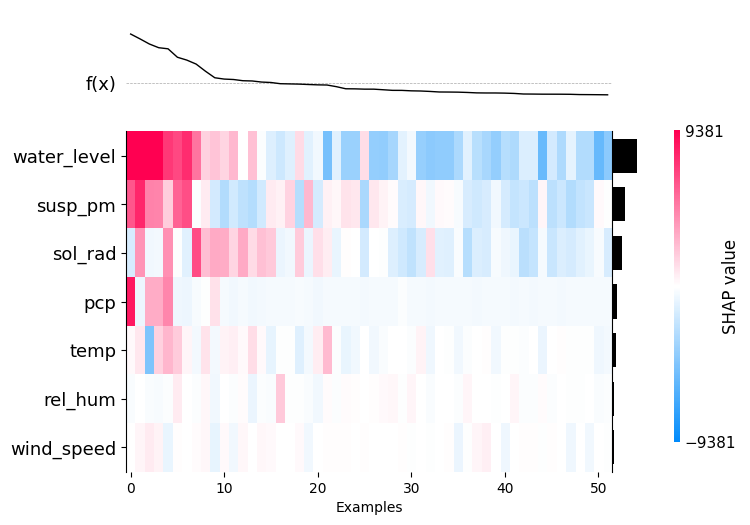

In [32]:
explainer.heatmap(show=True)

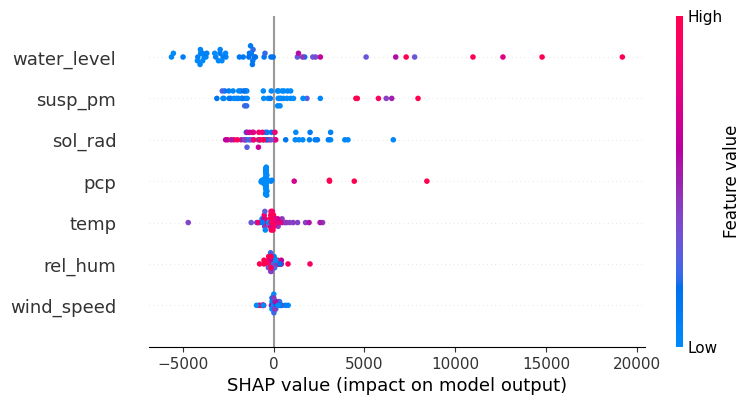

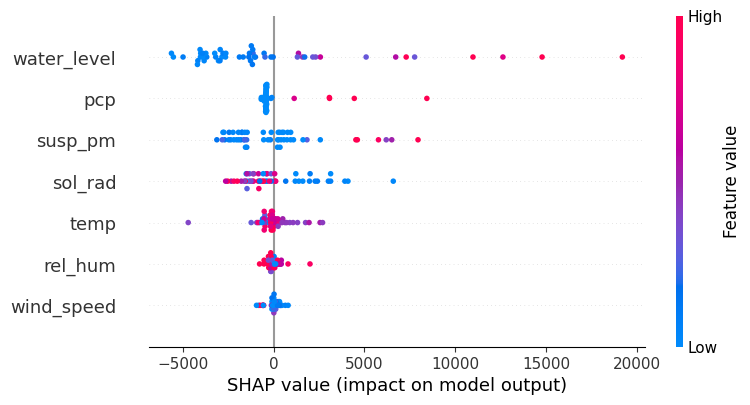

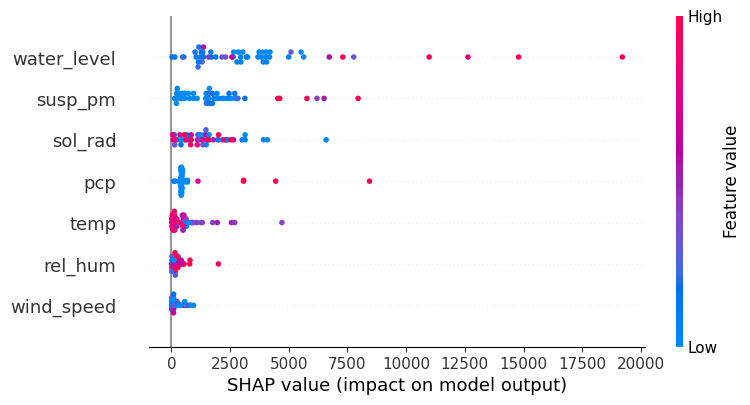

In [33]:
explainer.beeswarm_plot(show=True)

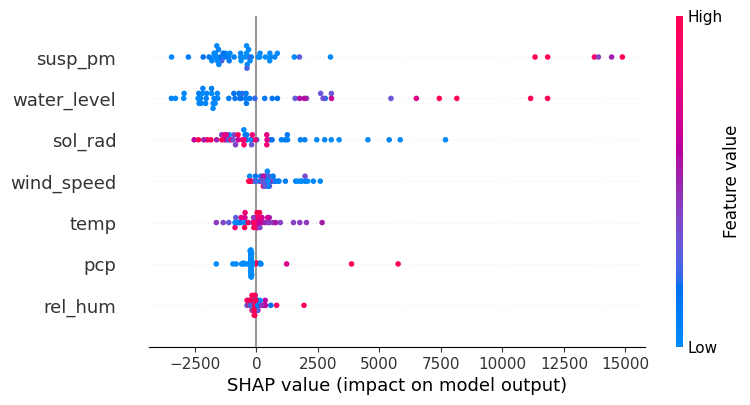

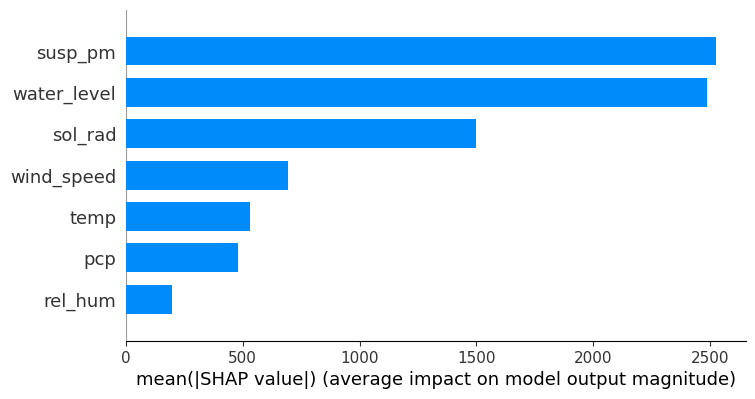

<Figure size 640x480 with 0 Axes>

In [34]:
explainer.summary_plot(show=True)

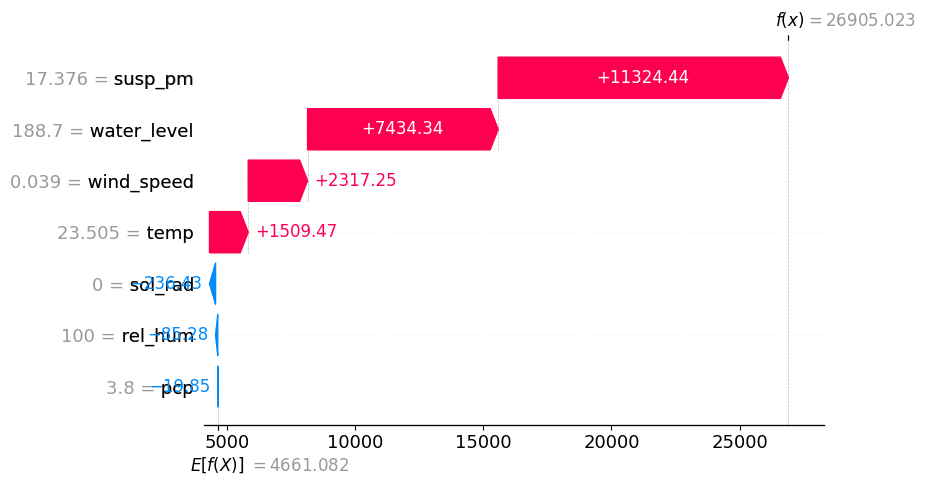

In [35]:
explainer.waterfall_plot_single_example(0)

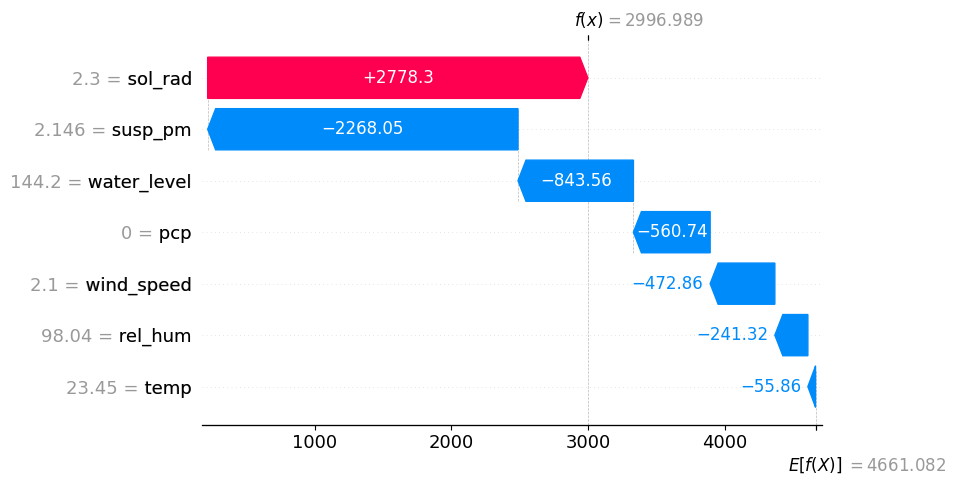

In [77]:
explainer.waterfall_plot_single_example(40)

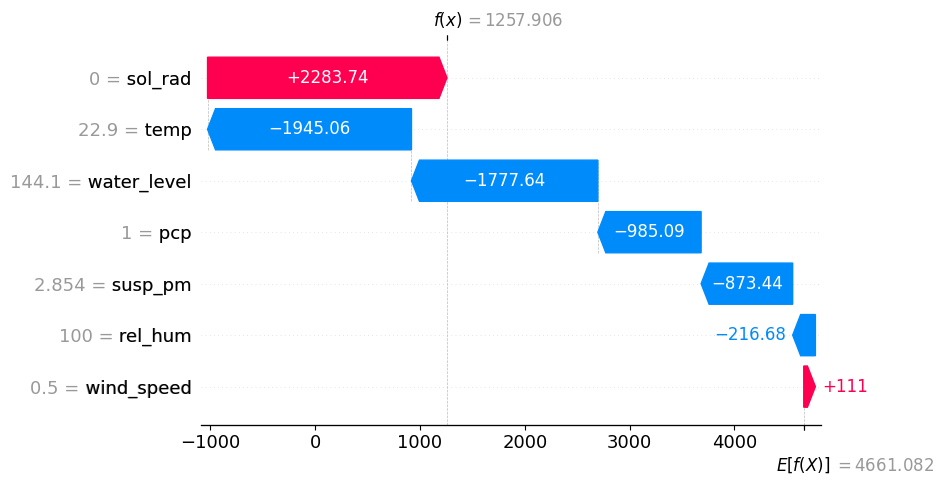

In [78]:
explainer.waterfall_plot_single_example(41)

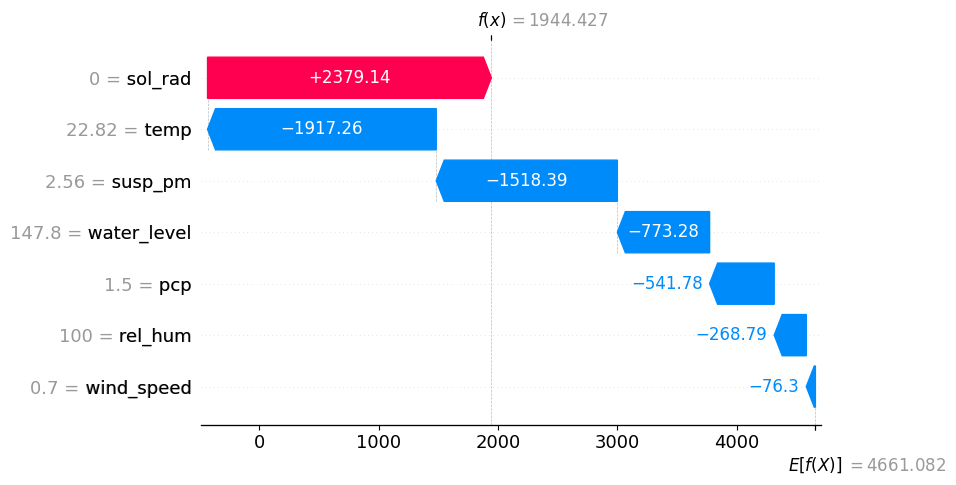

In [79]:
explainer.waterfall_plot_single_example(42)

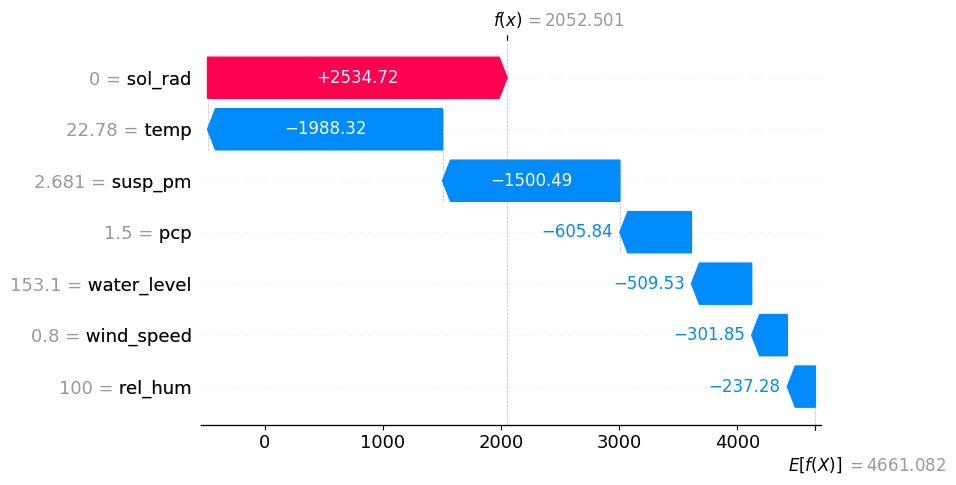

In [80]:
explainer.waterfall_plot_single_example(43)

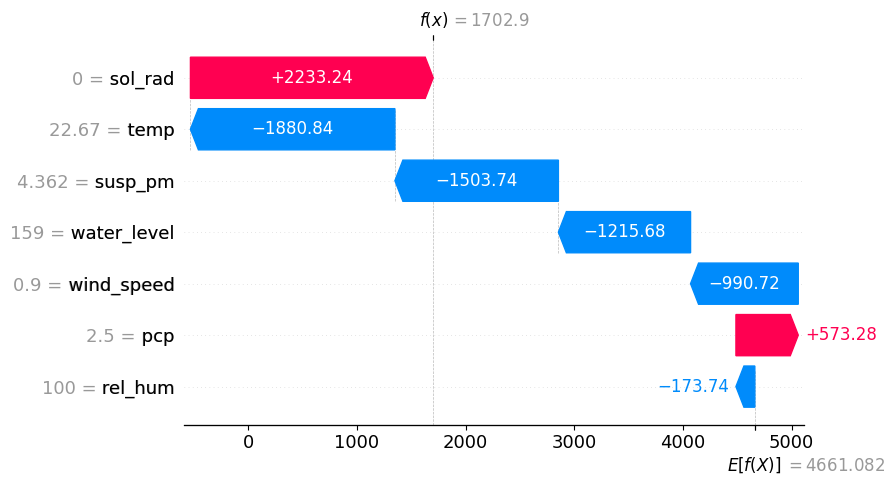

In [81]:
explainer.waterfall_plot_single_example(44)

### force plots

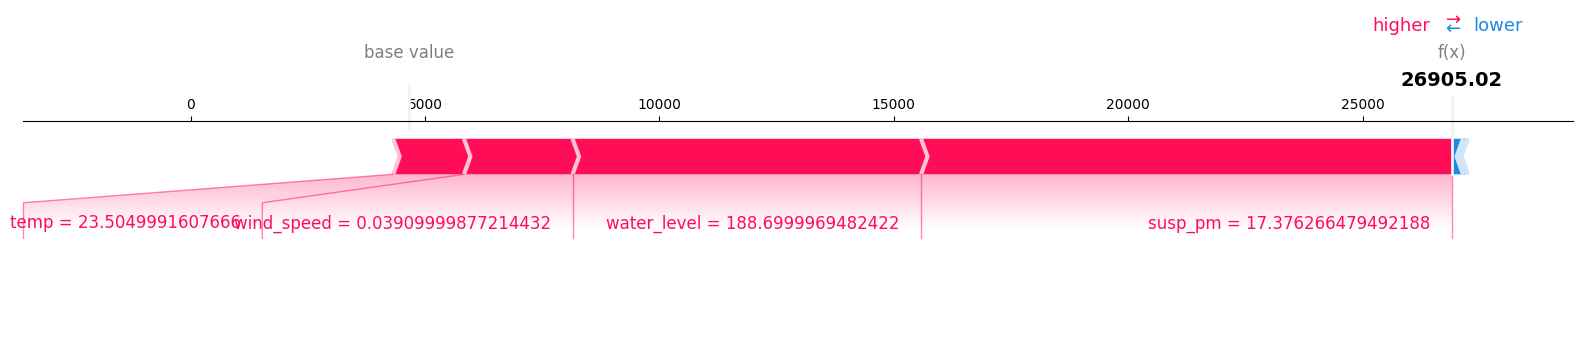

In [39]:
explainer.force_plot_single_example(0)

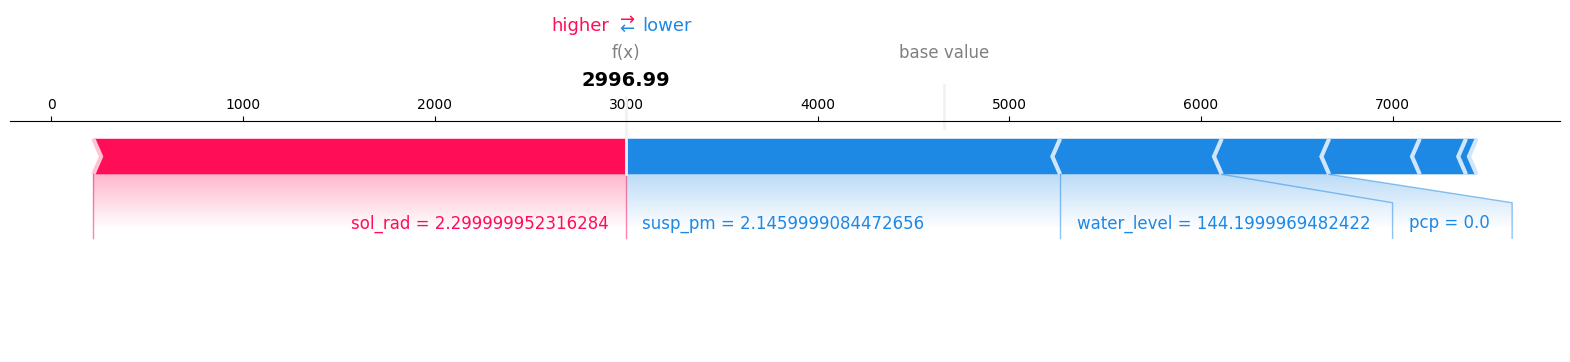

In [82]:
explainer.force_plot_single_example(40)

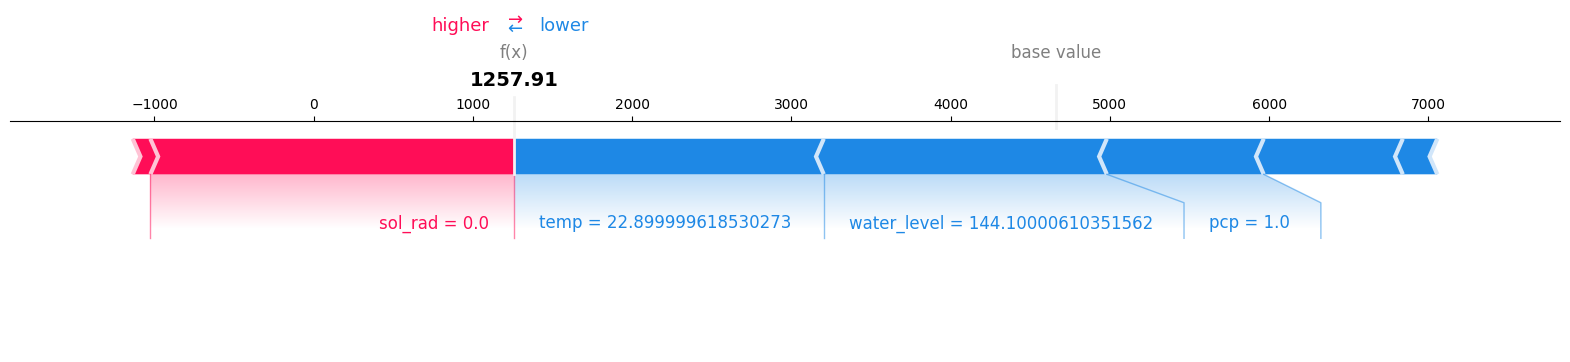

In [83]:
explainer.force_plot_single_example(41)

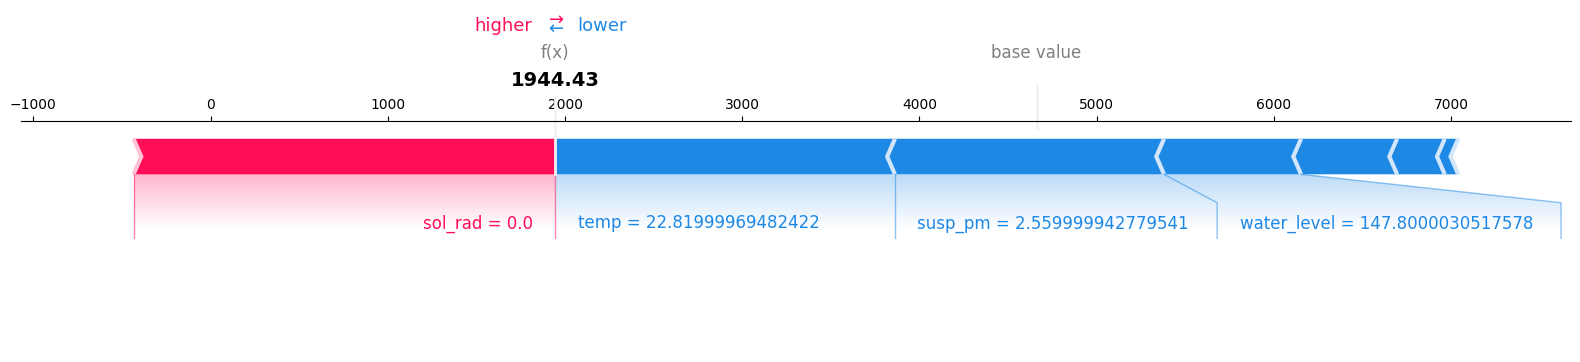

In [84]:
explainer.force_plot_single_example(42)

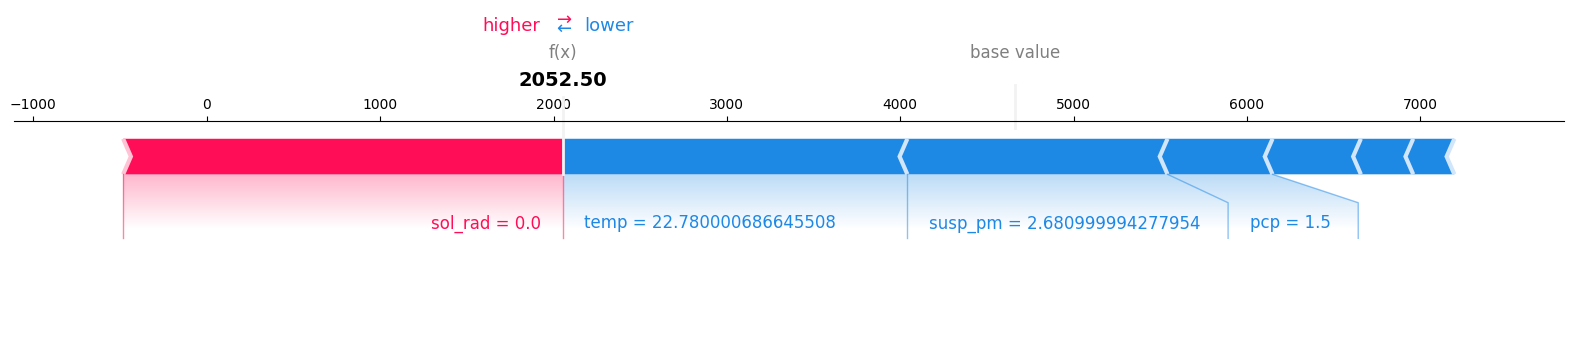

In [85]:
explainer.force_plot_single_example(43)

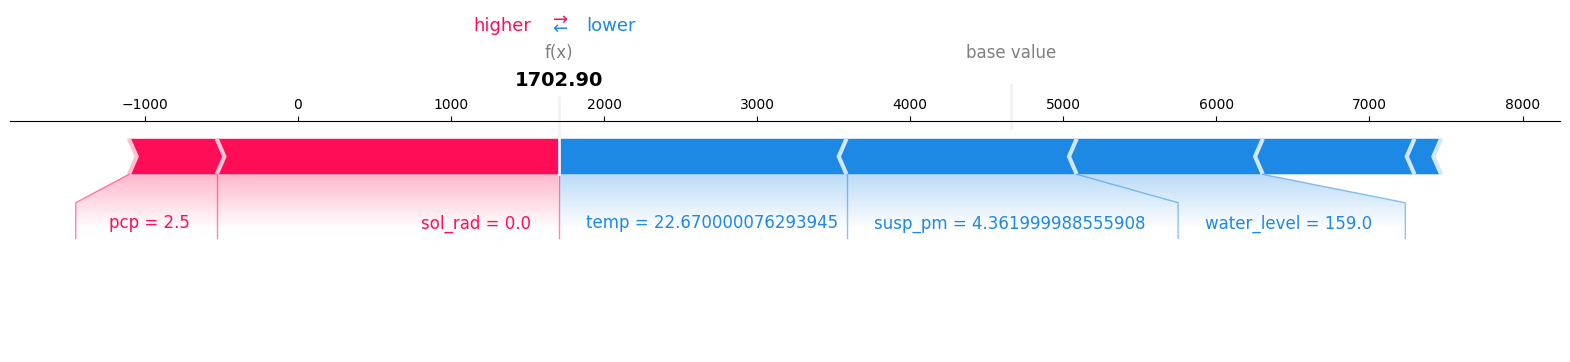

In [86]:
explainer.force_plot_single_example(44)

### scatter plots

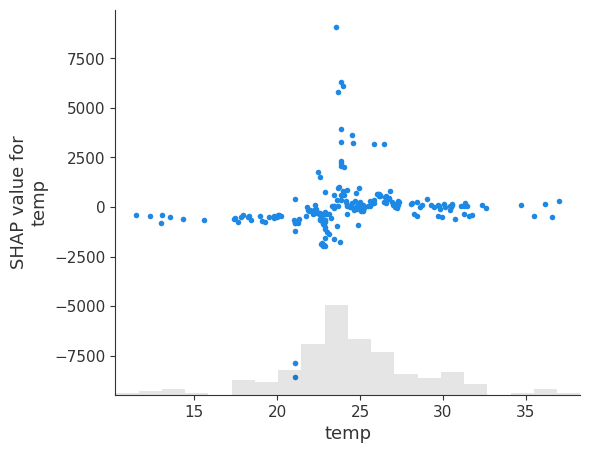

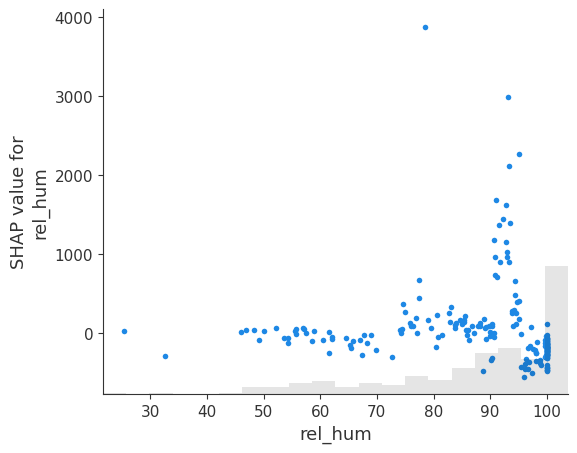

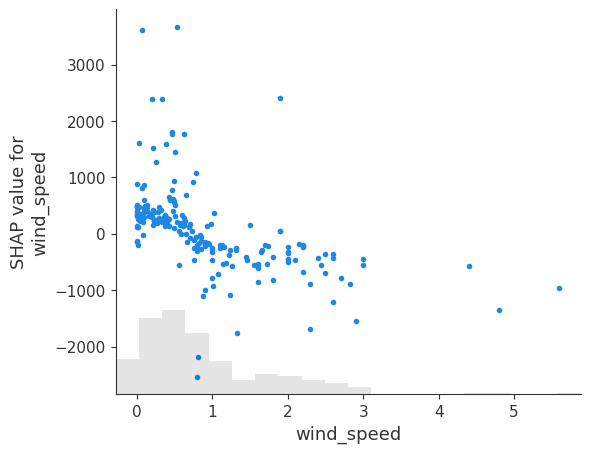

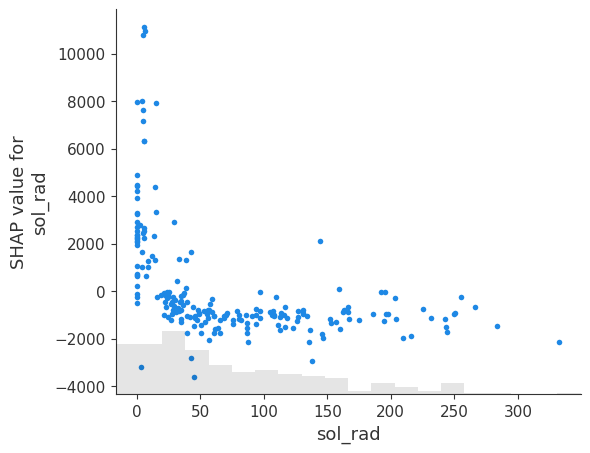

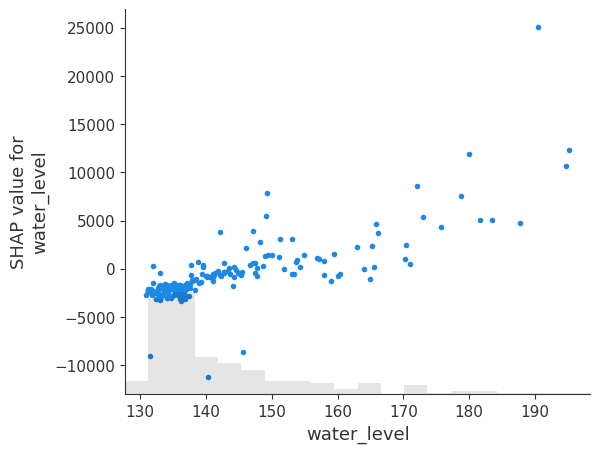

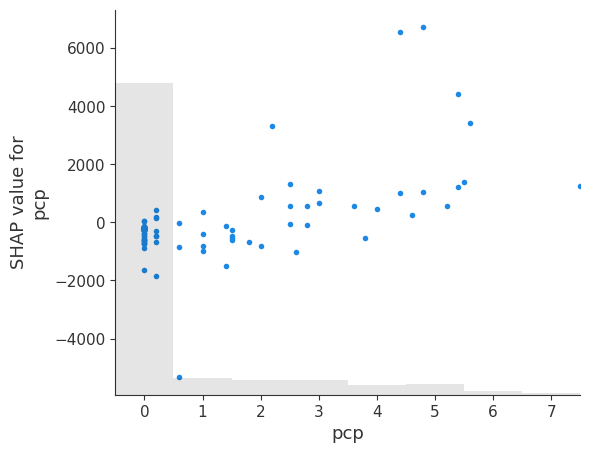

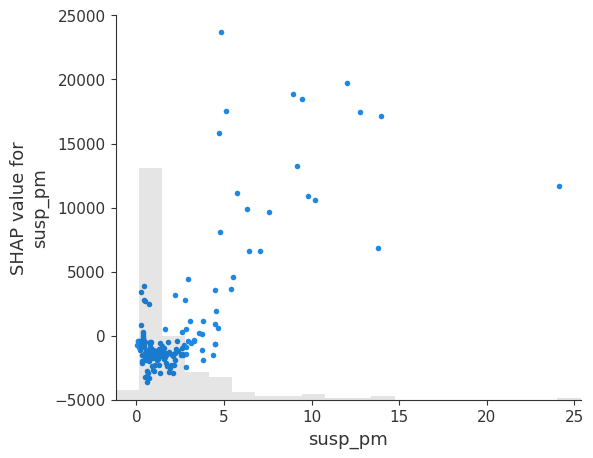

In [87]:
explainer.scatter_plot_all_features()

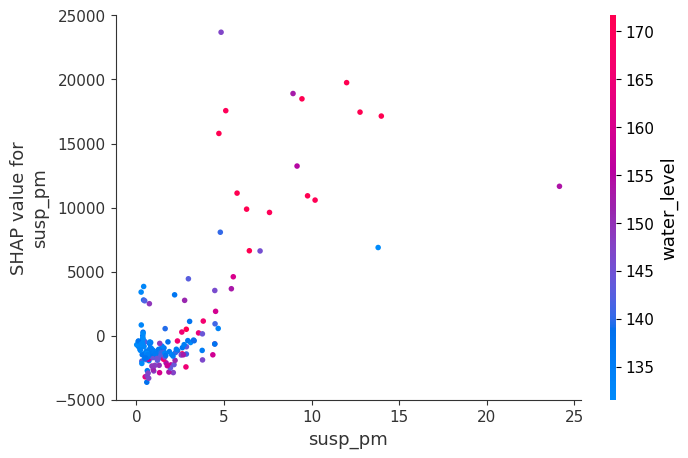

In [88]:
explainer.dependence_plot_single_feature('susp_pm')

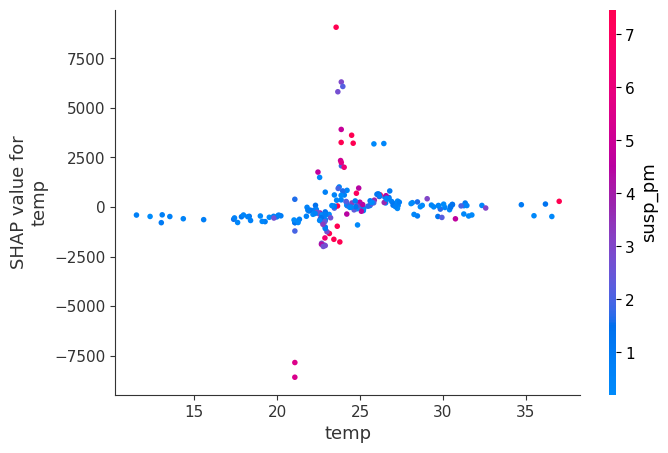

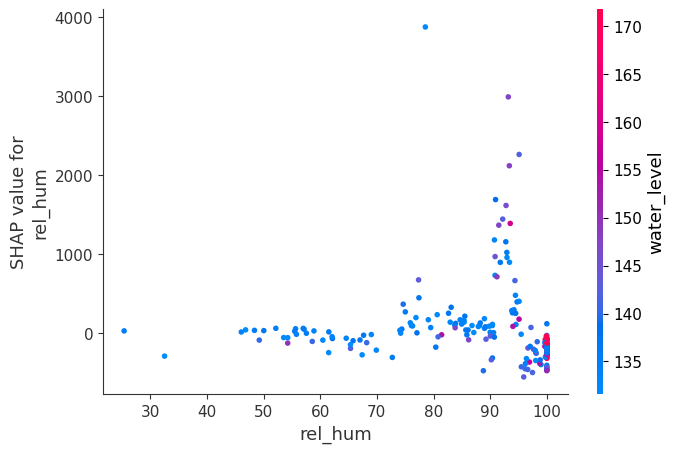

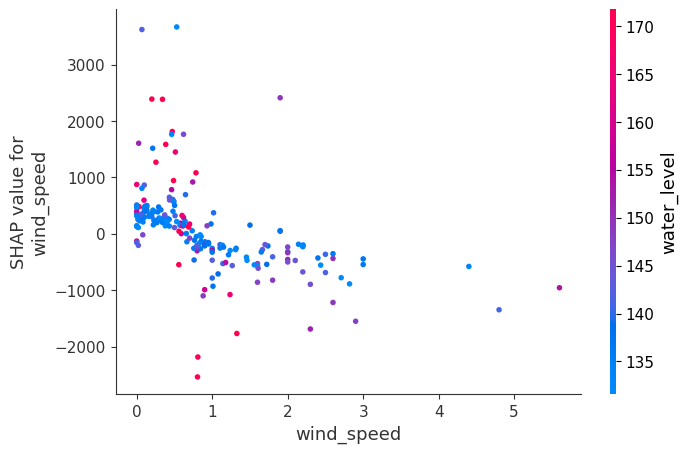

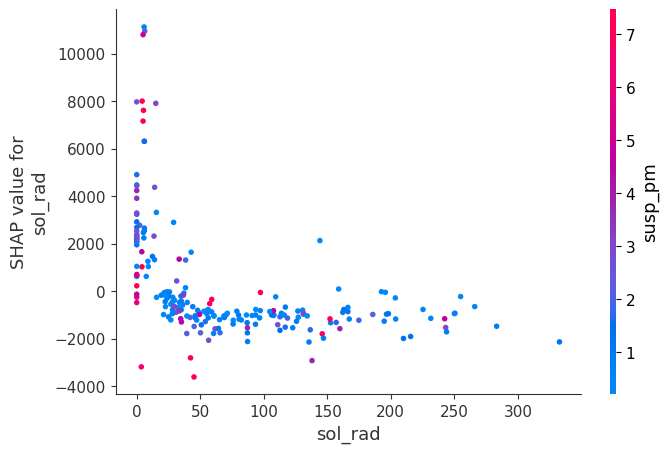

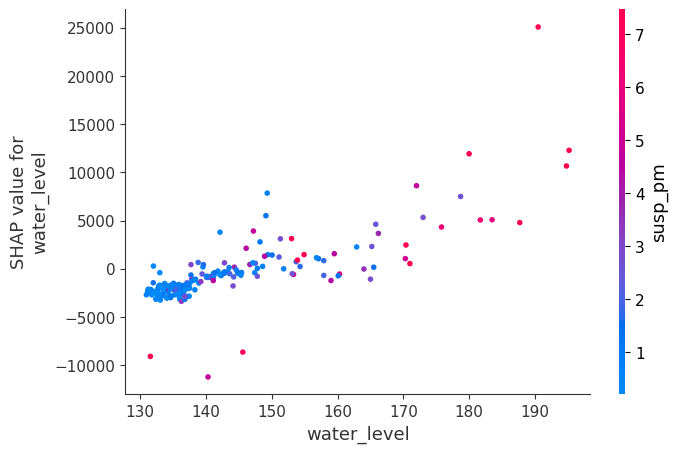

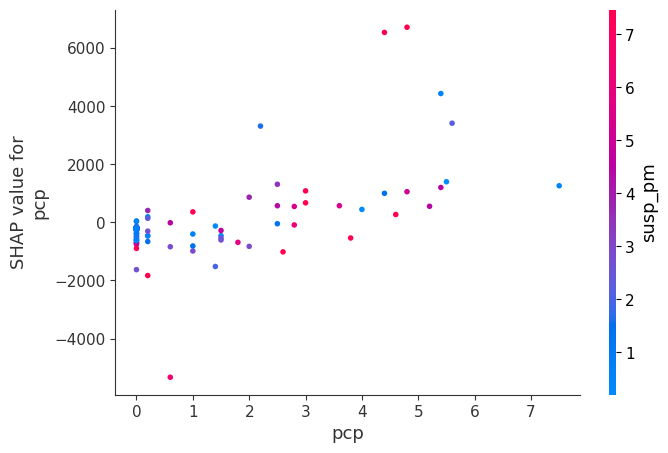

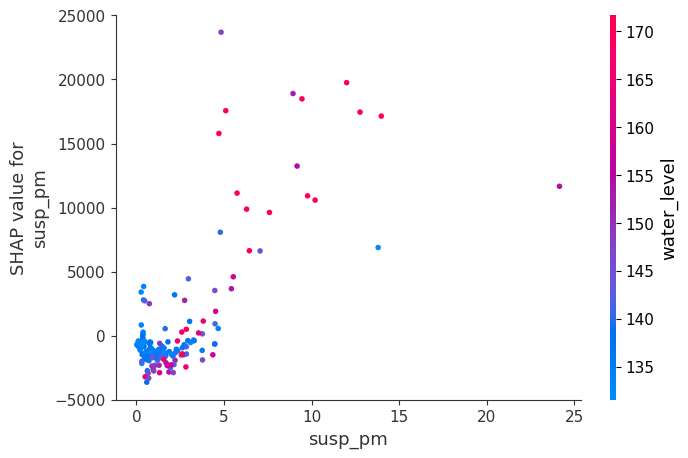

In [89]:
explainer.dependence_plot_all_features(show=True)

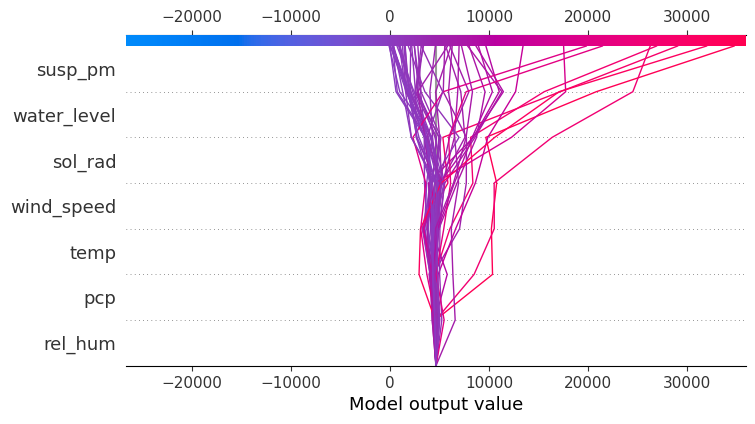

<Figure size 640x480 with 0 Axes>

In [47]:
explainer.decision_plot(show=True)

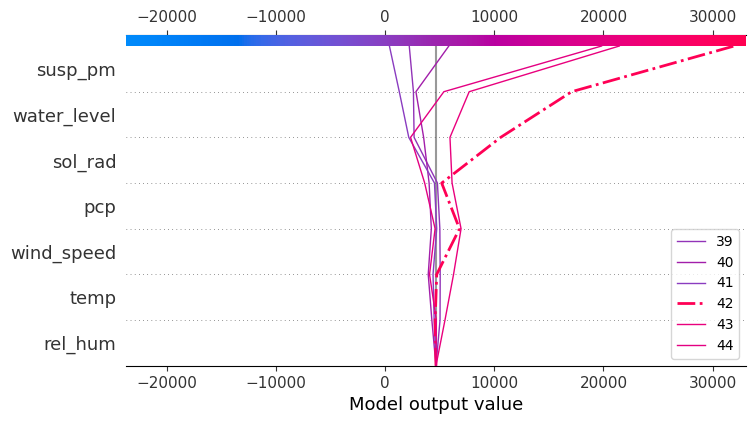

<Figure size 640x480 with 0 Axes>

In [48]:
explainer.decision_plot(indices=range(39, 45), show=True, highlight=3)

In [90]:
explainer.force_plot_all()

# Explaination on Training data

In [91]:
for idx,t,p in zip(range(len(train_y_true)), train_y_true, train_y_pred):
    print(idx, t, p)

0 [[1100.]] 1092.5492
1 [[1400.]] 1404.9572
2 [[14000.]] 13999.804
3 [[1300.]] 1304.3998
4 [[29000.]] 28987.05
5 [[1700.]] 1707.197
6 [[1000.]] 1001.8603
7 [[340.]] 341.30188
8 [[500.]] 499.58783
9 [[360.]] 359.11014
10 [[250.]] 247.49588
11 [[2000.]] 1997.1451
12 [[120.]] 120.20438
13 [[1400.]] 1397.2782
14 [[460.]] 463.39948
15 [[390.]] 391.10556
16 [[120.]] 119.576385
17 [[0.]] 0.84151083
18 [[160.]] 158.58104
19 [[120.]] 116.38566
20 [[78.]] 78.15899
21 [[38.]] 40.70081
22 [[350.]] 349.89682
23 [[210.]] 208.99673
24 [[120.]] 120.631805
25 [[360.]] 367.34427
26 [[78.]] 79.131195
27 [[120.]] 121.83899
28 [[250.]] 251.18839
29 [[2100.]] 2098.4324
30 [[2075.]] 2076.4973
31 [[21000.]] 20998.479
32 [[49000.]] 49000.254
33 [[26000.]] 26000.309
34 [[9900.]] 9892.555
35 [[830.]] 829.3118
36 [[210.]] 208.85713
37 [[700.]] 698.49854
38 [[900.]] 898.6219
39 [[1200.]] 1200.4172
40 [[3000.]] 2996.987
41 [[1250.]] 1257.9043
42 [[1950.]] 1944.4254
43 [[2050.]] 2052.499
44 [[1700.]] 1702.8987
45 [[

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

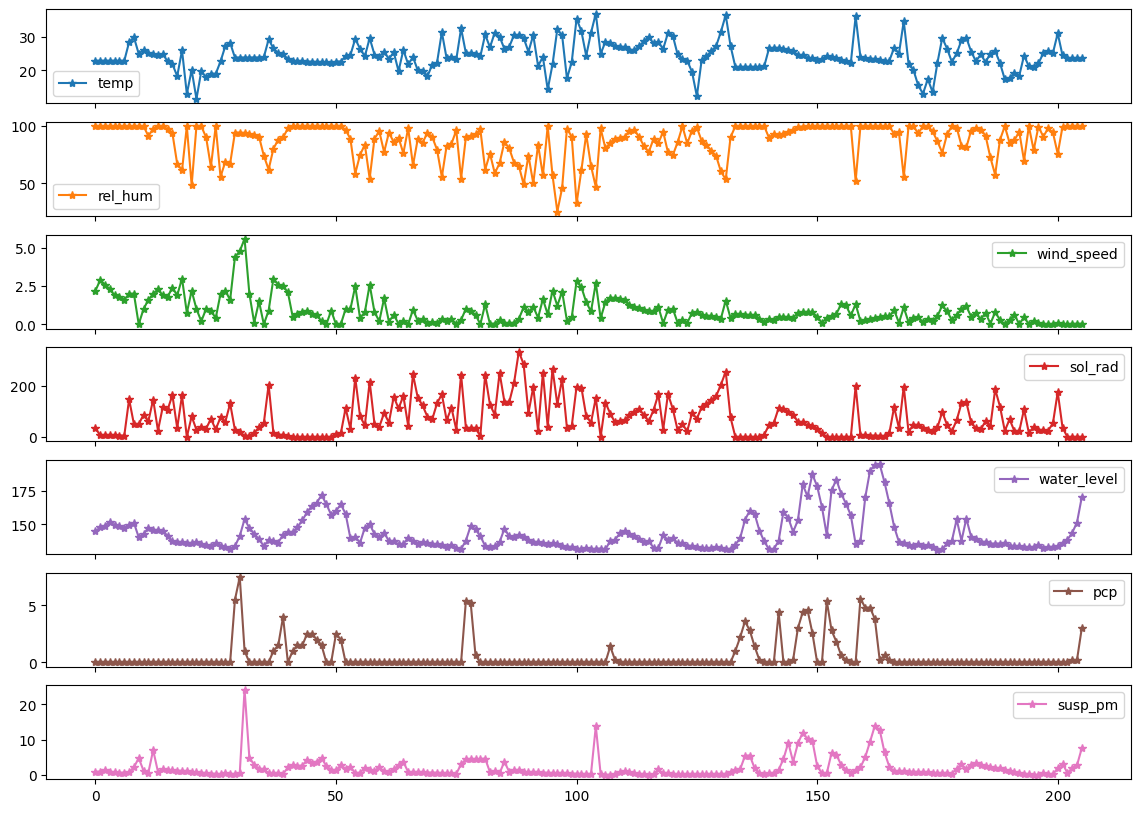

In [92]:
pd.DataFrame(train_x, columns=model.config['input_features']).plot(subplots=True, 
                                                                  figsize=(14, 10),
                                                                 style="-*")

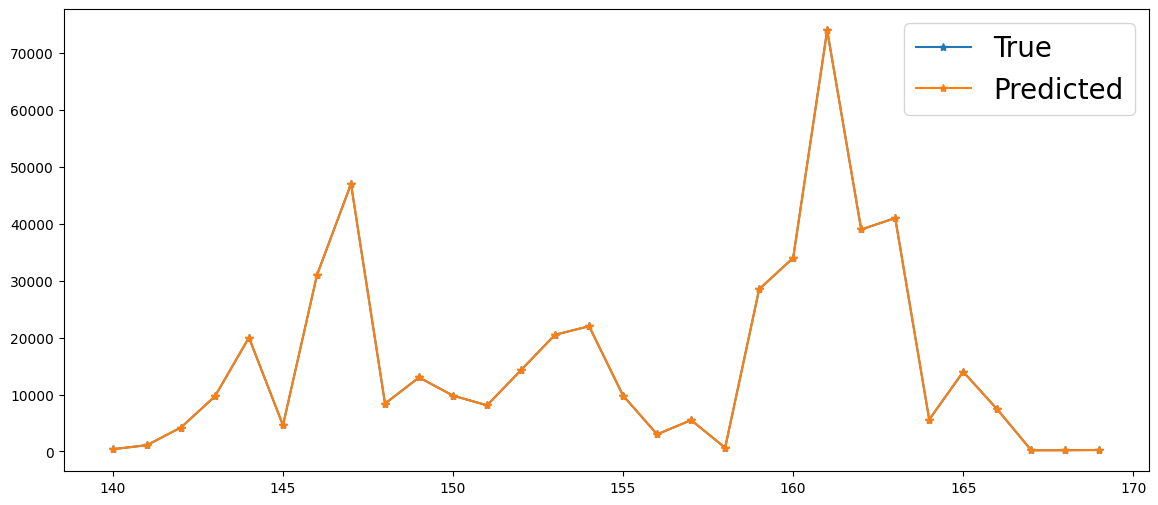

In [93]:
_, axis = plt.subplots(figsize=(14, 6))
axis.plot(range(140, 170), train_y_true[140:170].reshape(-1,), '-*', label="True")
axis.plot(range(140, 170), train_y_pred[140:170], '-*', label="Predicted")
axis.legend(fontsize=20)
plt.show()

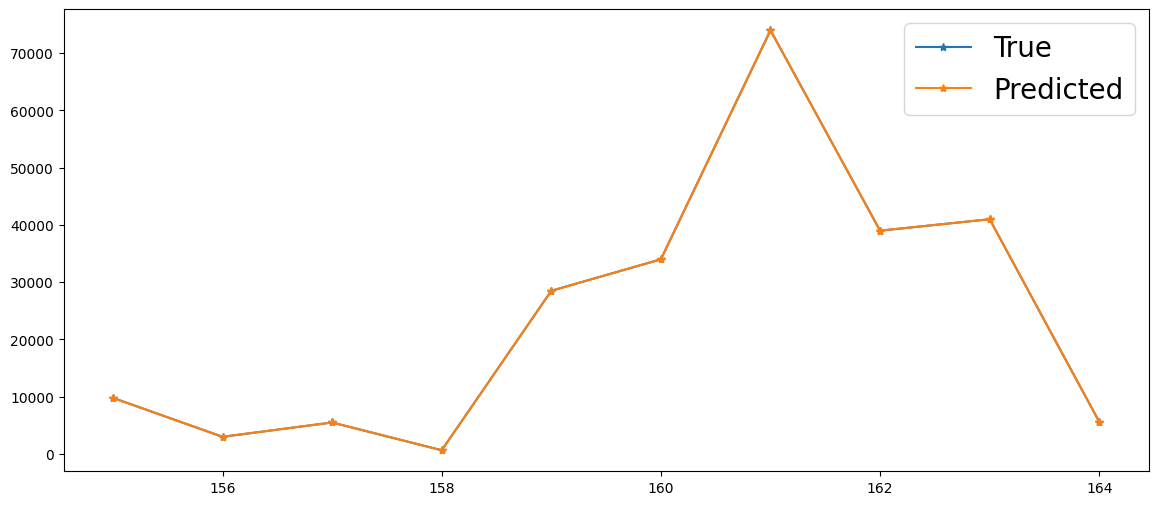

In [94]:
_, axis = plt.subplots(figsize=(14, 6))
axis.plot(range(155, 165), train_y_true[155:165].reshape(-1,), '-*', label="True")
axis.plot(range(155, 165), train_y_pred[155:165], '-*', label="Predicted")
axis.legend(fontsize=20)
plt.show()

FixedFormatter should only be used together with FixedLocator


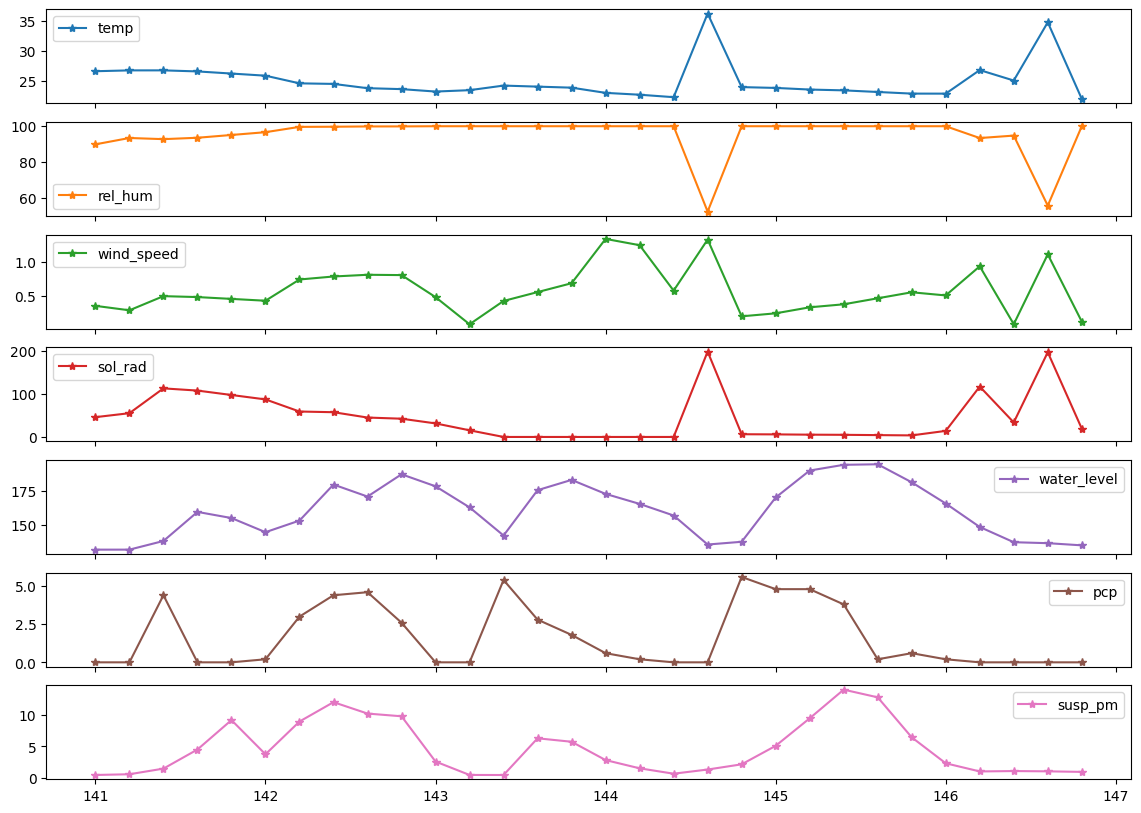

In [95]:
axis = pd.DataFrame(train_x[140:170], columns=model.config['input_features']).plot(subplots=True, 
                                                                  figsize=(14, 10),
                                                                 style="-*")

for ax in axis:
    ax.set_xticklabels(range(140, 170))

In [96]:
explainer = ShapExplainer(model._model,
                          train_x,
                          train_data=train_x, # the data on which model was trained
                          path=model.path,
                          features=model.dh.input_features, # names of features
                          num_means=10,
                          explainer="TreeExplainer"
                         )

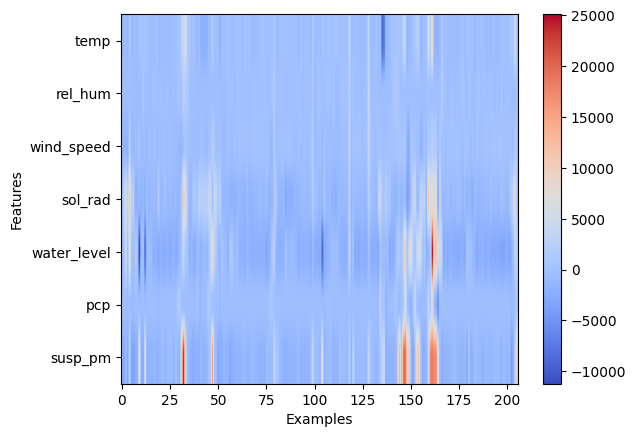

In [97]:
explainer.plot_shap_values()

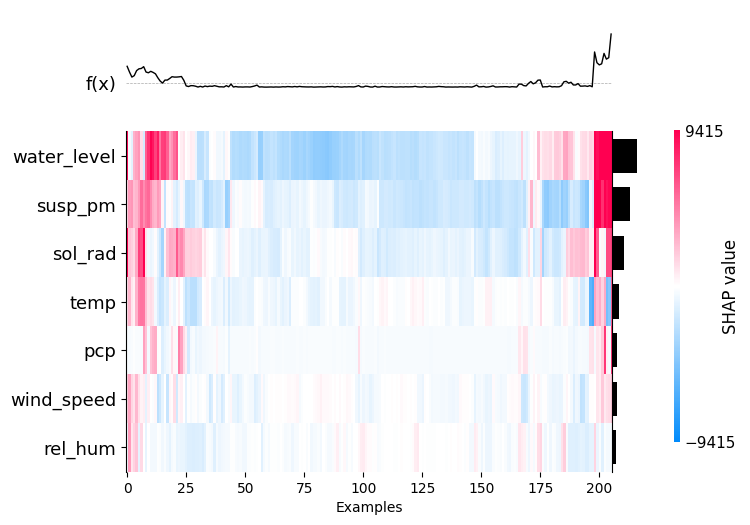

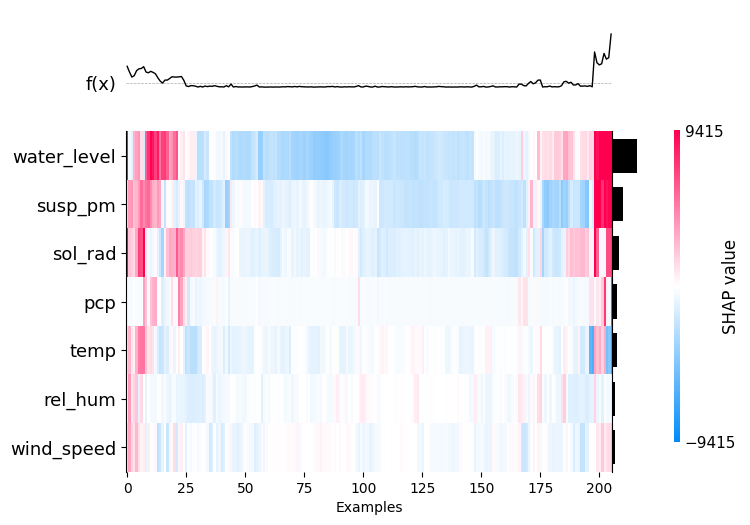

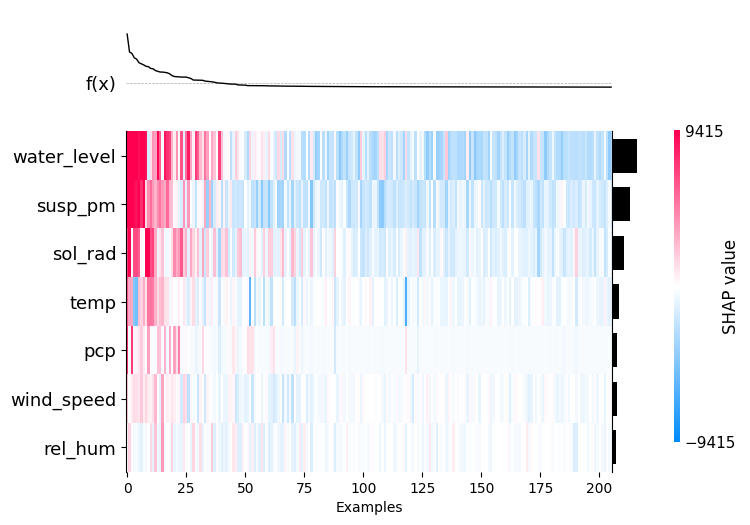

In [98]:
explainer.heatmap(show=True)

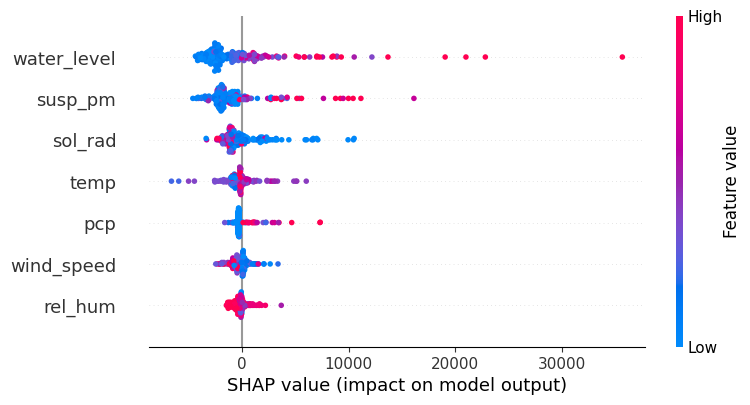

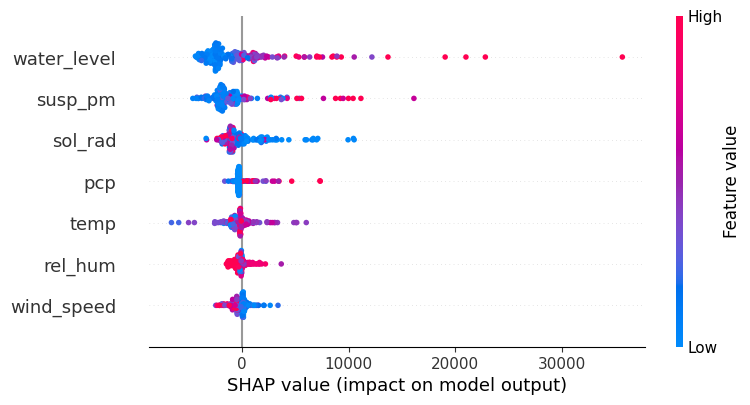

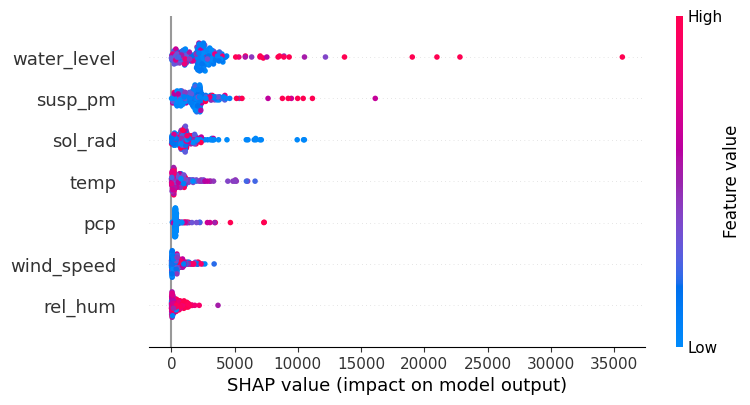

In [99]:
explainer.beeswarm_plot(show=True)

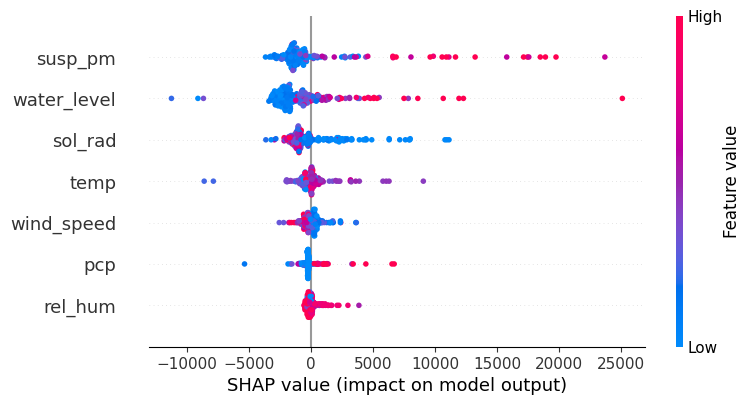

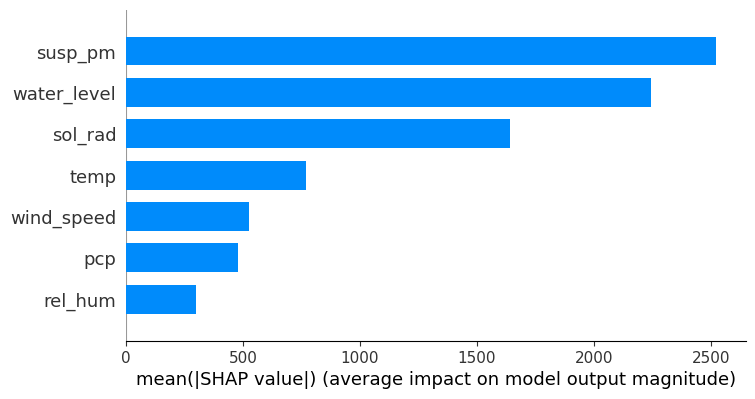

<Figure size 640x480 with 0 Axes>

In [100]:
explainer.summary_plot(show=True)

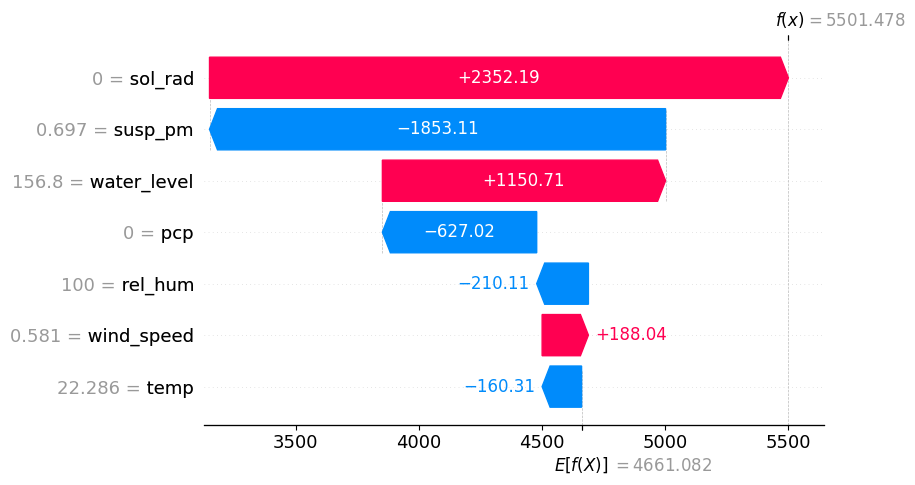

In [101]:
explainer.waterfall_plot_single_example(157)

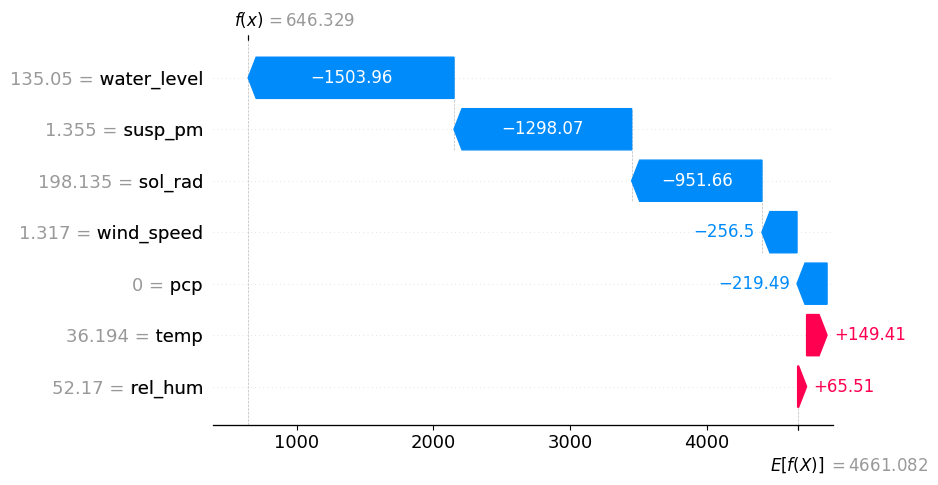

In [102]:
explainer.waterfall_plot_single_example(158)

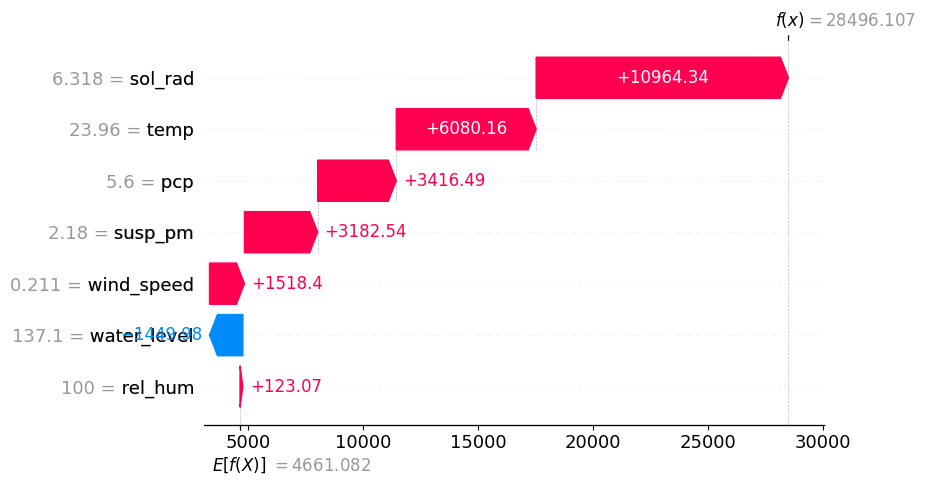

In [103]:
explainer.waterfall_plot_single_example(159)

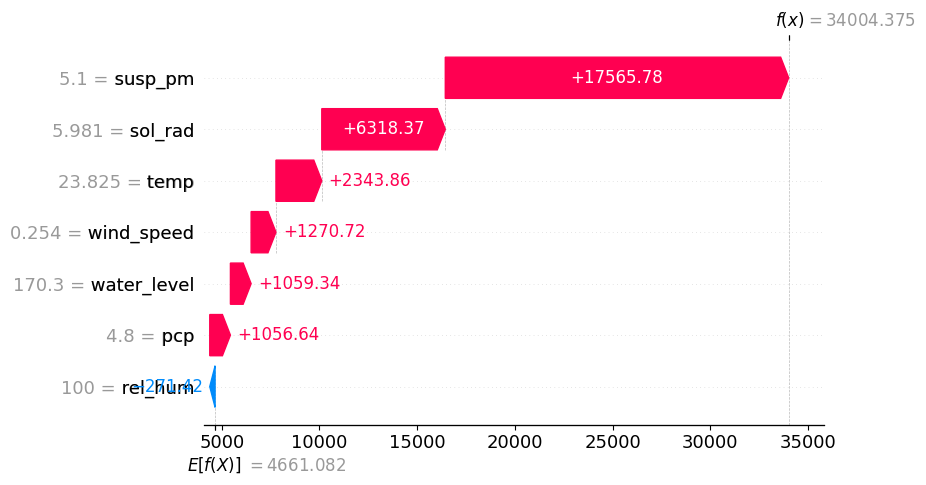

In [104]:
explainer.waterfall_plot_single_example(160)

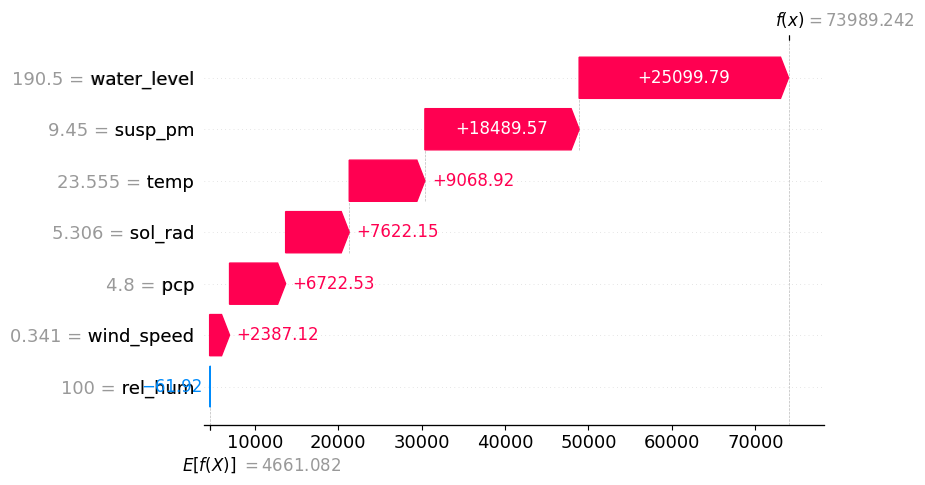

In [105]:
explainer.waterfall_plot_single_example(161)

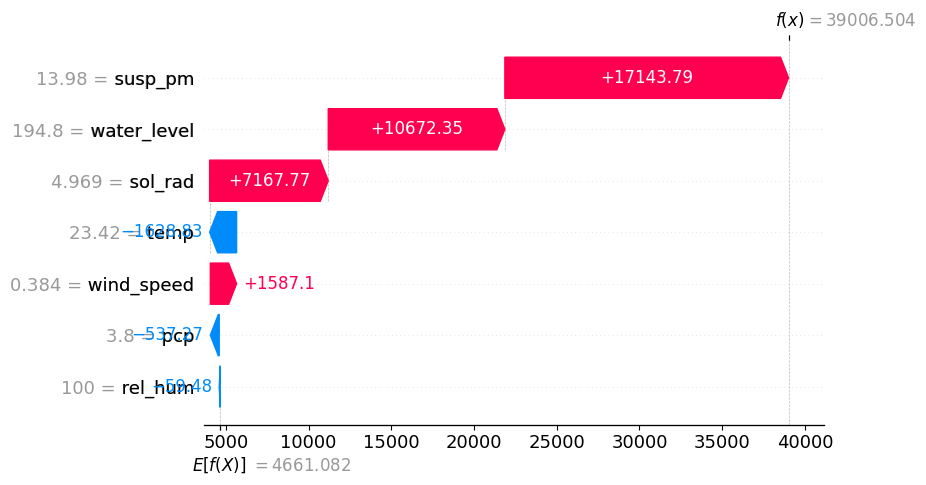

In [106]:
explainer.waterfall_plot_single_example(162)

## force plots

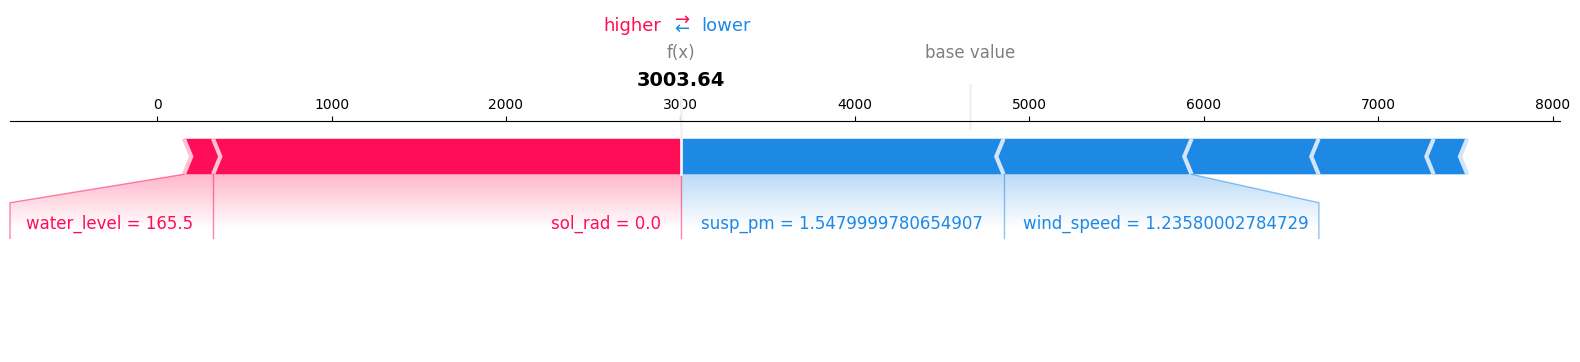

In [107]:
explainer.force_plot_single_example(156)

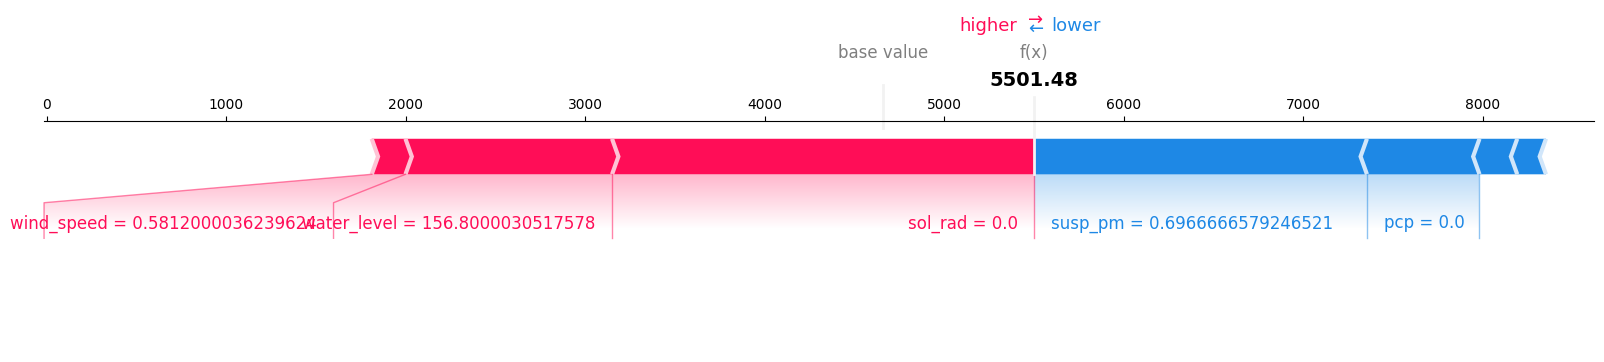

In [108]:
explainer.force_plot_single_example(157)

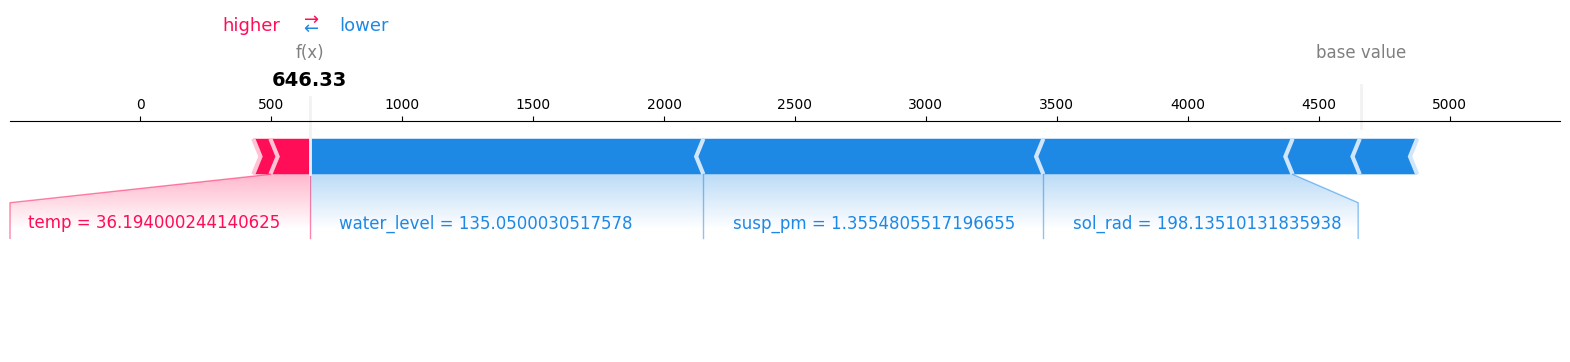

In [109]:
explainer.force_plot_single_example(158)

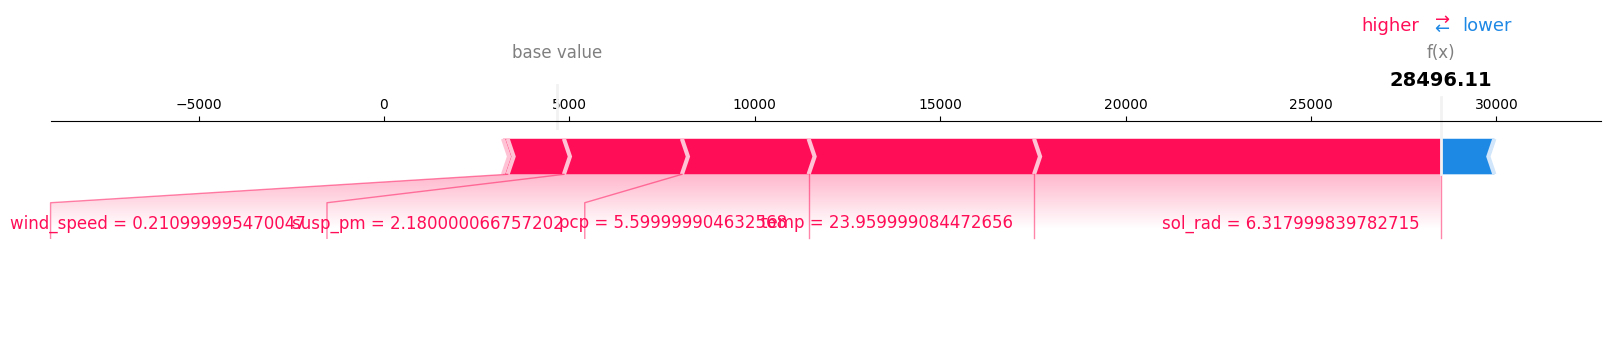

In [110]:
explainer.force_plot_single_example(159)

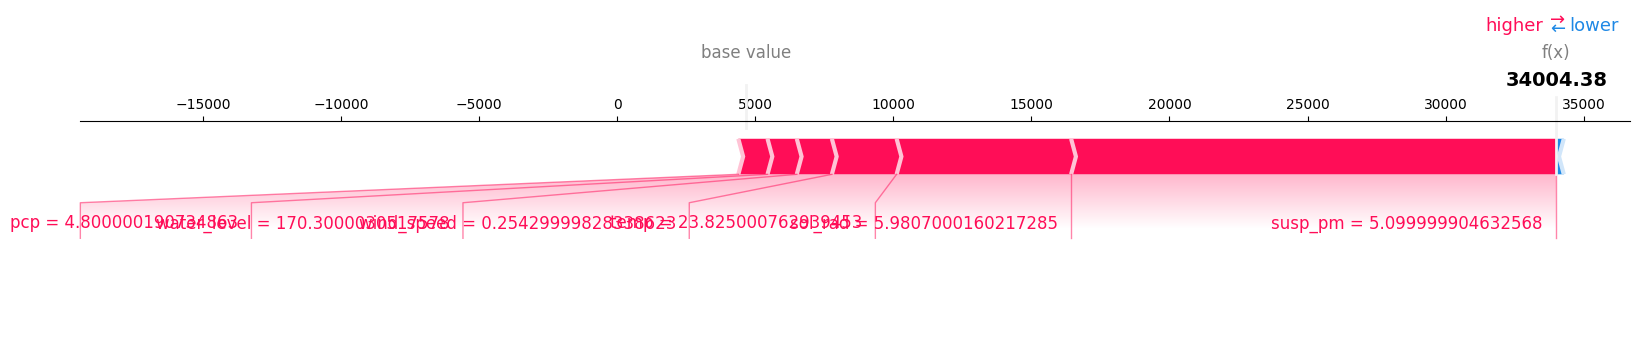

In [111]:
explainer.force_plot_single_example(160)

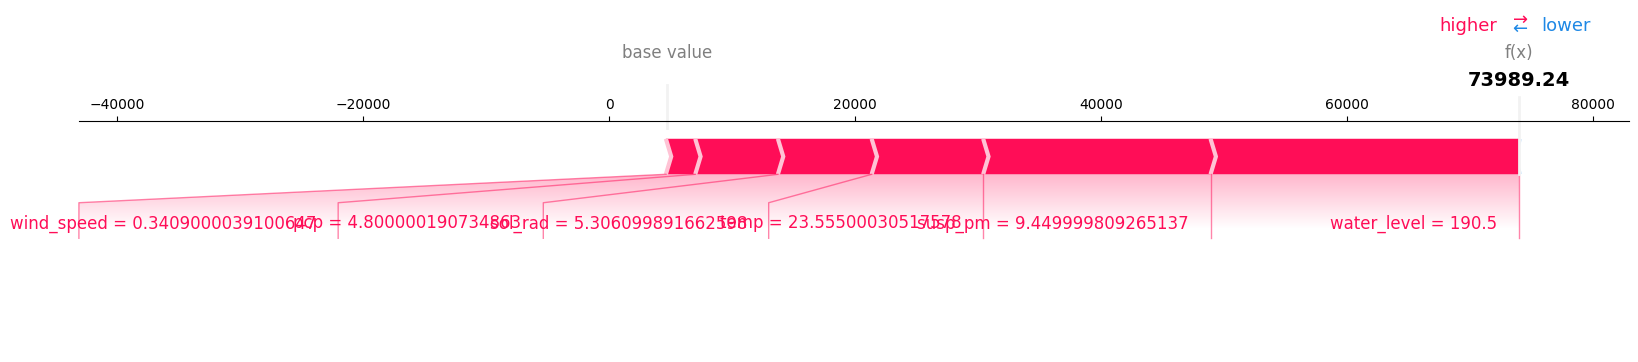

In [112]:
explainer.force_plot_single_example(161)

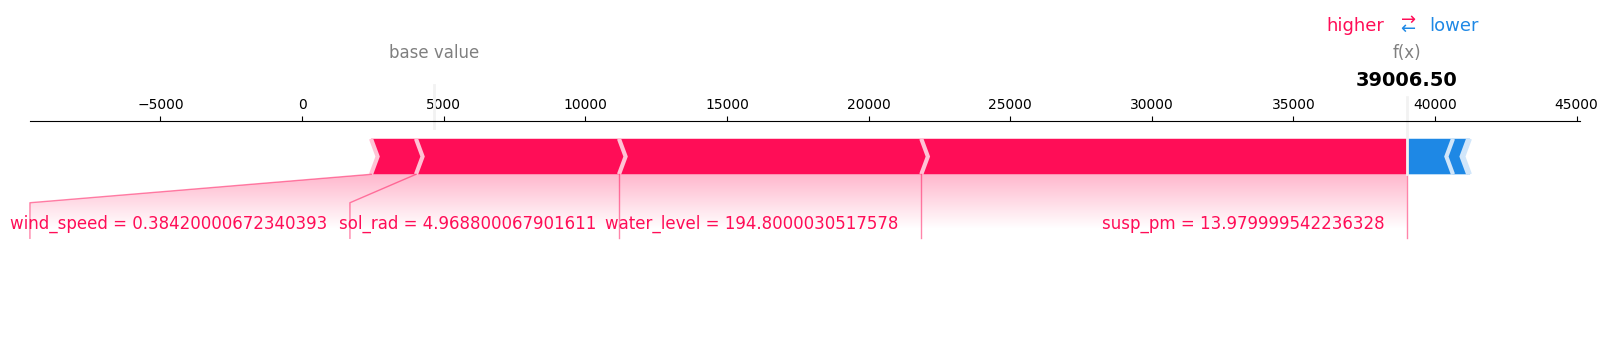

In [113]:
explainer.force_plot_single_example(162)

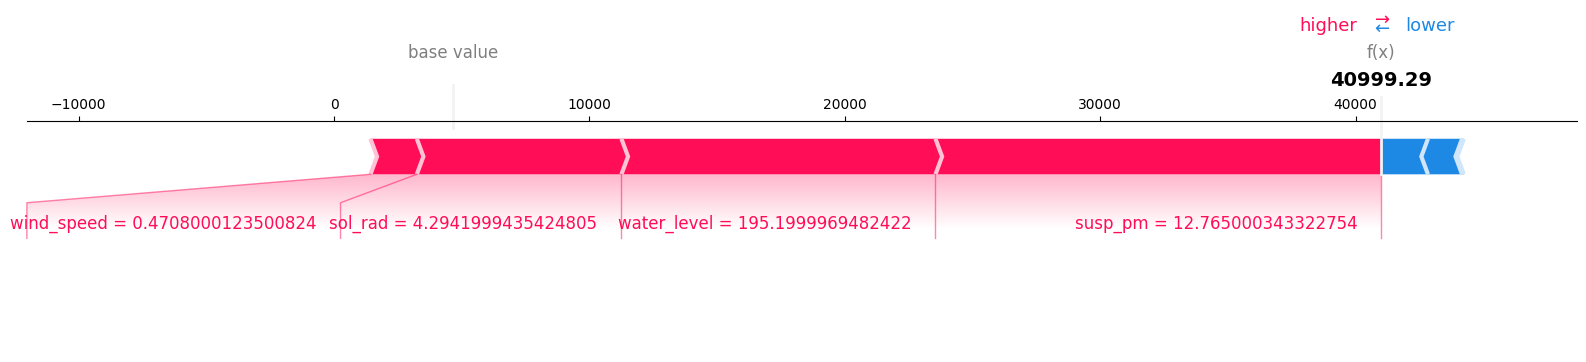

In [114]:
explainer.force_plot_single_example(163)

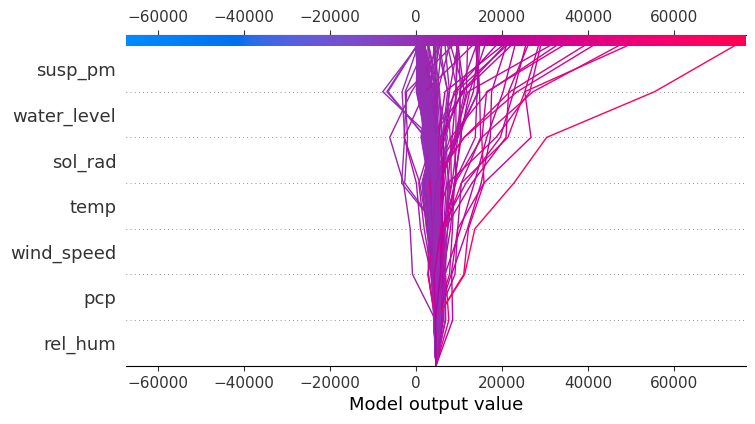

<Figure size 640x480 with 0 Axes>

In [115]:
explainer.decision_plot()

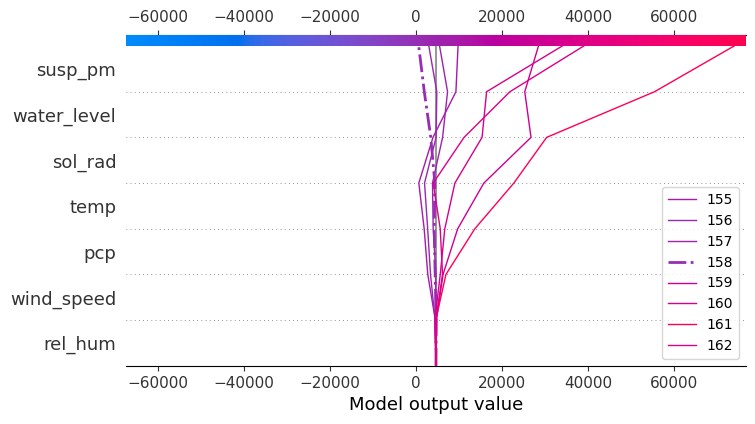

<Figure size 640x480 with 0 Axes>

In [116]:
explainer.decision_plot(indices=range(155, 163), highlight=3)

interaction between different SHAP values

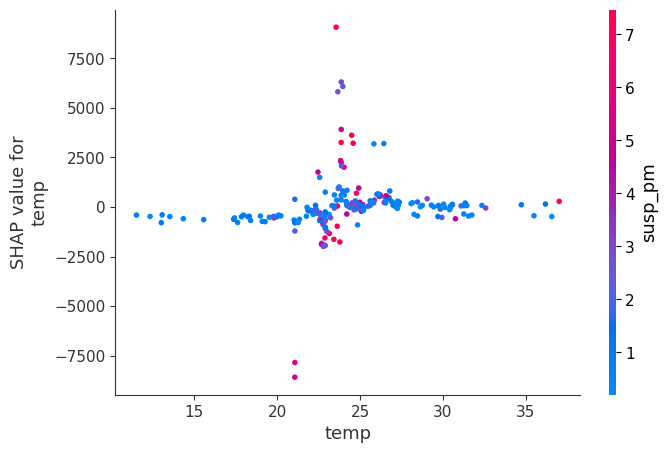

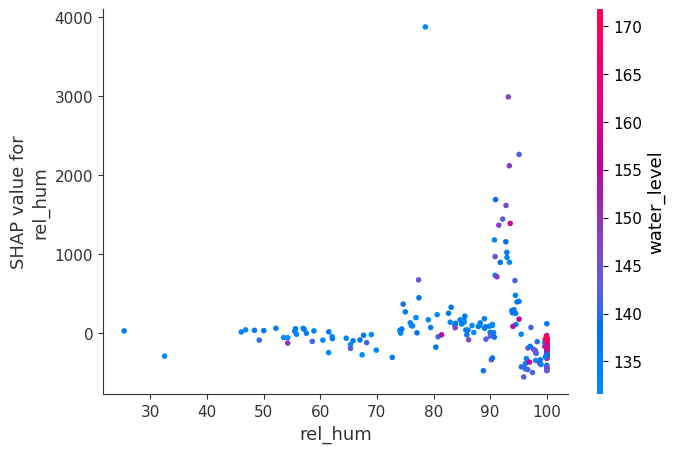

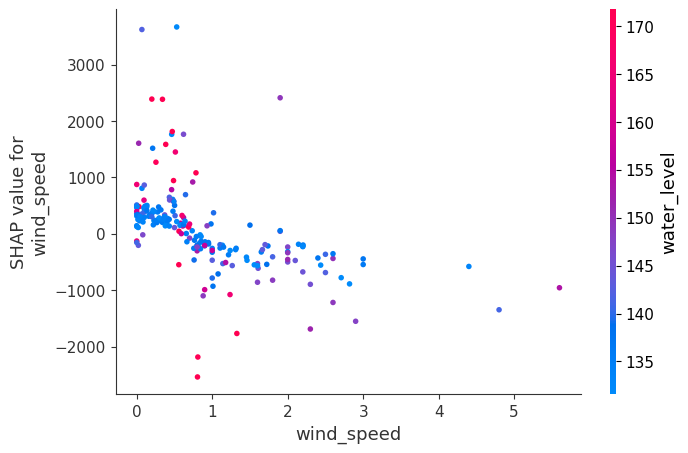

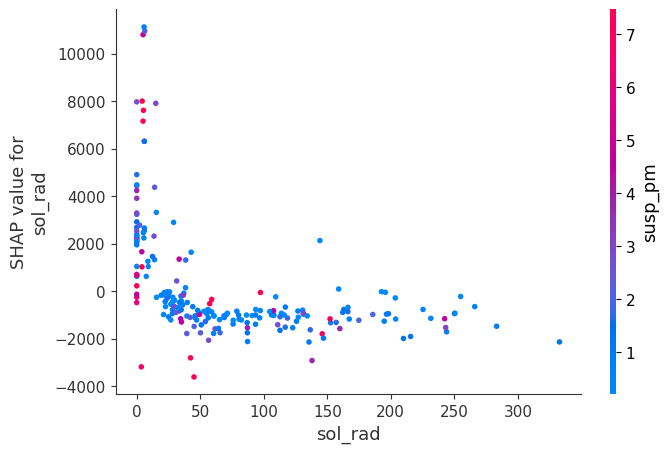

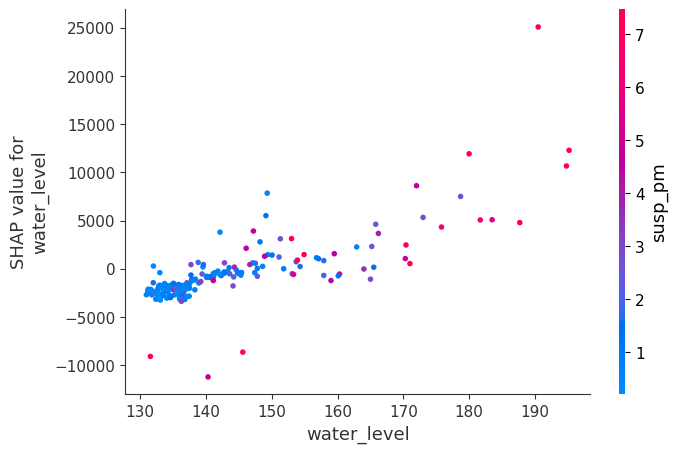

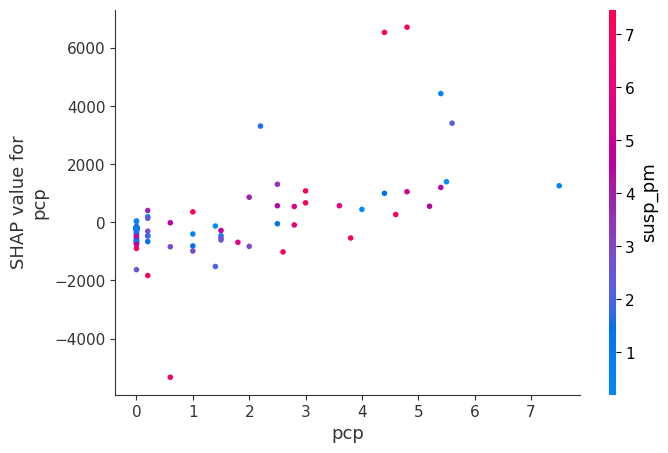

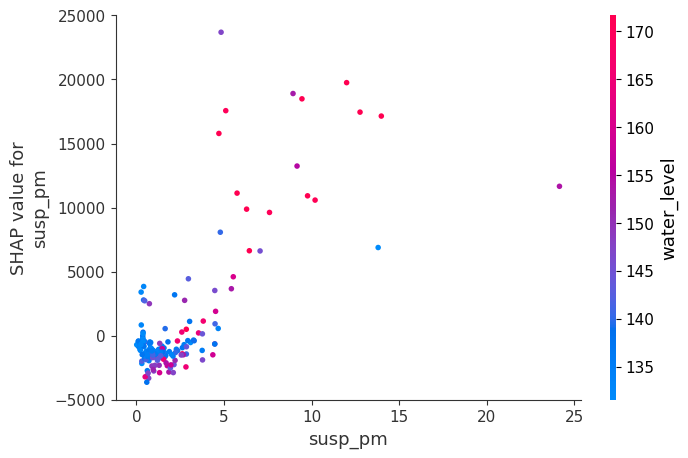

In [117]:
explainer.dependence_plot_all_features(show=True)

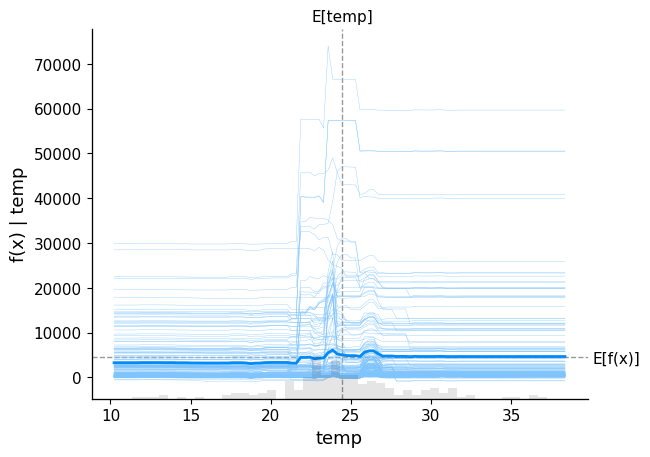

<Figure size 640x480 with 0 Axes>

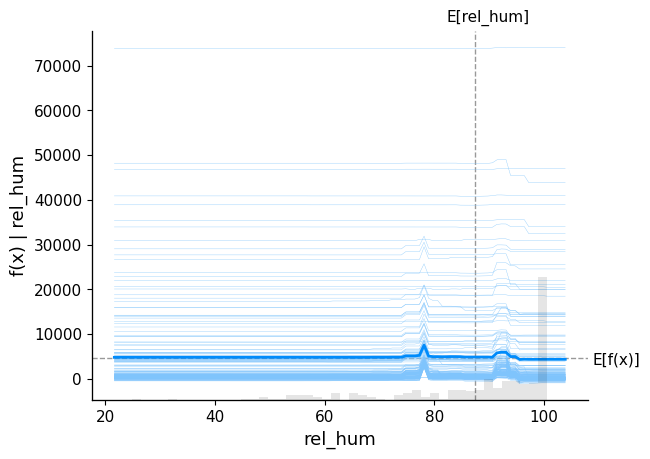

<Figure size 640x480 with 0 Axes>

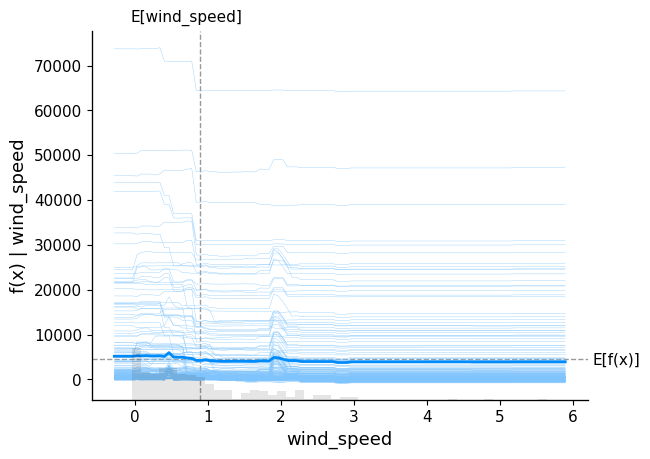

<Figure size 640x480 with 0 Axes>

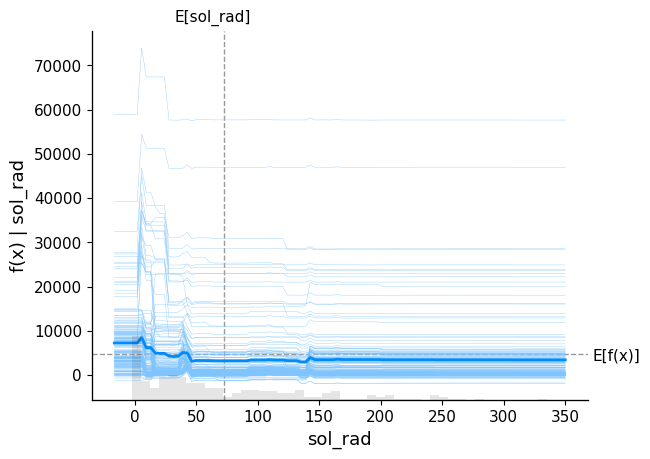

<Figure size 640x480 with 0 Axes>

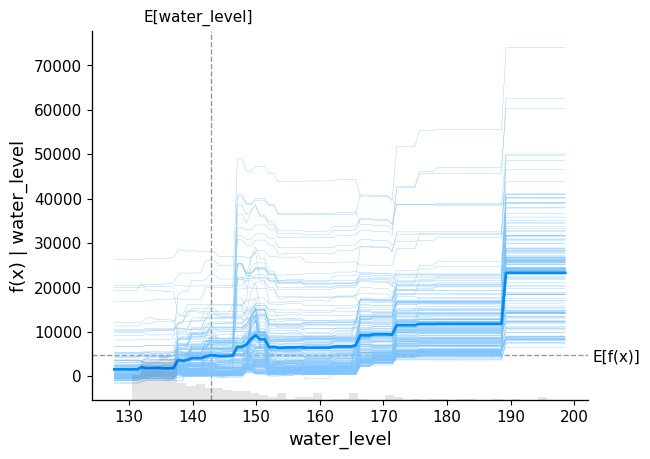

<Figure size 640x480 with 0 Axes>

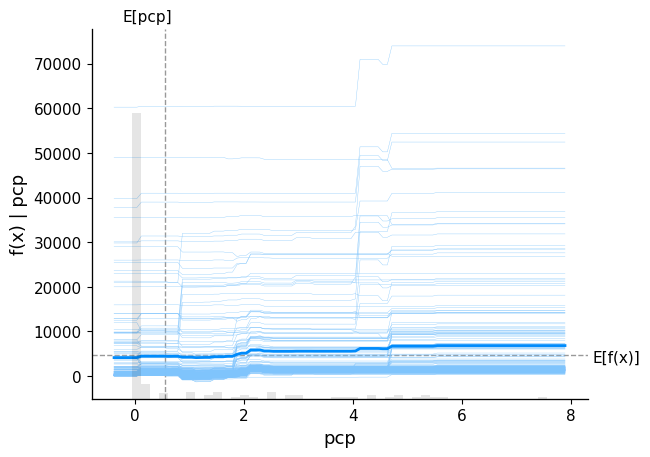

<Figure size 640x480 with 0 Axes>

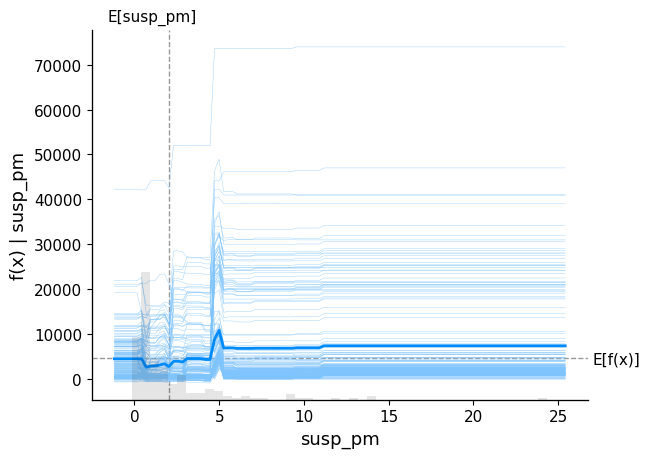

<Figure size 640x480 with 0 Axes>

In [118]:
explainer.pdp_all_features(show=True)

FixedFormatter should only be used together with FixedLocator


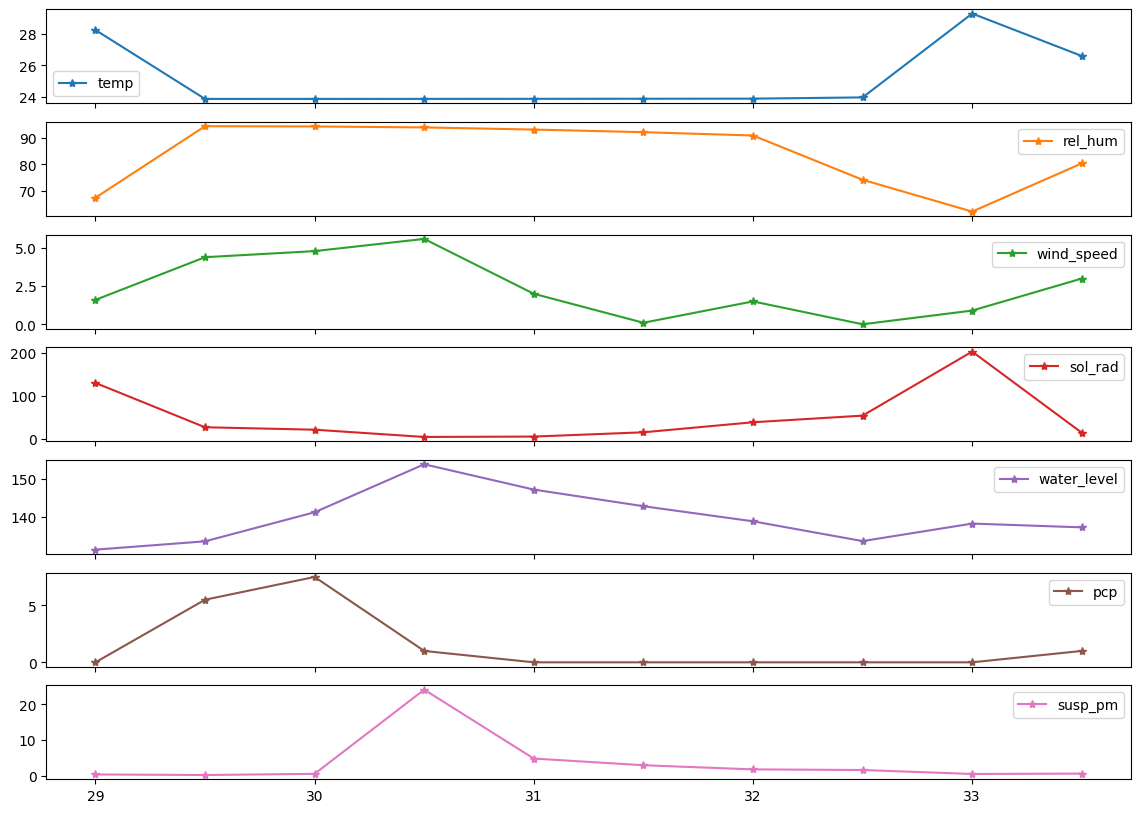

In [119]:
st, en = 28, 38
axis = pd.DataFrame(train_x[st:en], columns=model.config['input_features']).plot(subplots=True, 
                                                                  figsize=(14, 10),
                                                                 style="-*")

for ax in axis:
    ax.set_xticklabels(range(st, en))

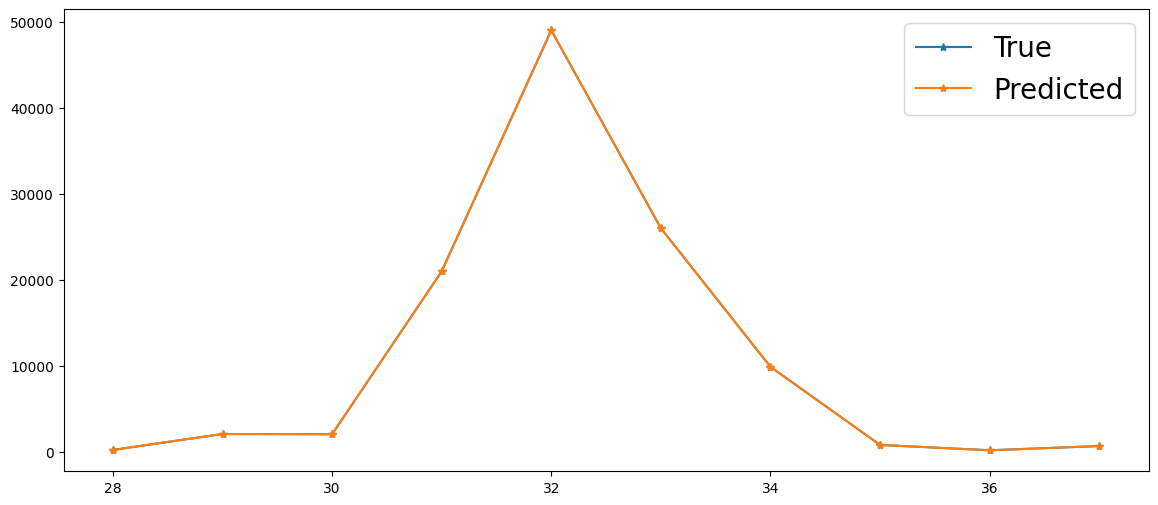

In [120]:
_, axis = plt.subplots(figsize=(14, 6))
axis.plot(range(st, en), train_y_true[st:en].reshape(-1,), '-*', label="True")
axis.plot(range(st, en), train_y_pred[st:en], '-*', label="Predicted")
axis.legend(fontsize=20)
plt.show()

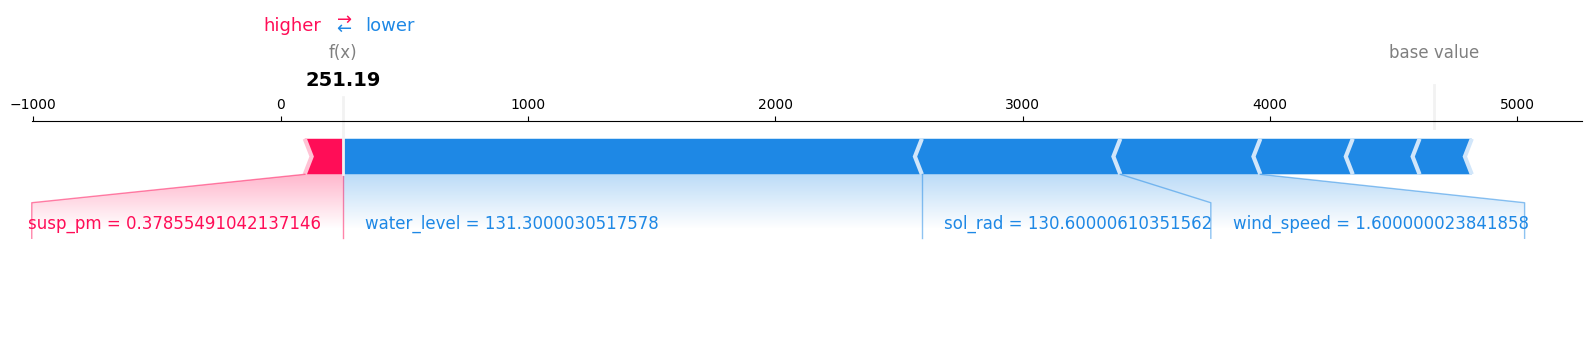

In [123]:
explainer.force_plot_single_example(28, show=True)

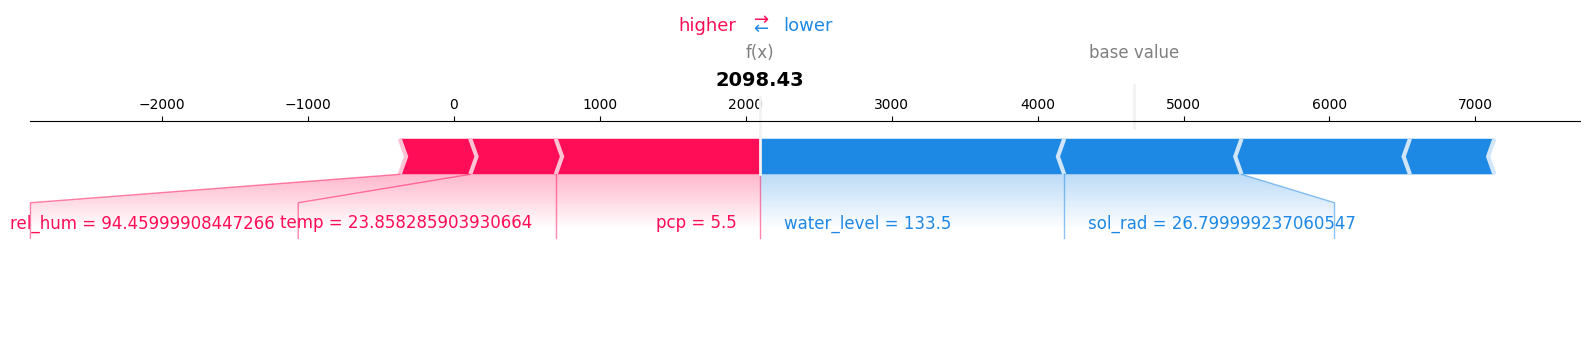

In [124]:
explainer.force_plot_single_example(29, show=True)

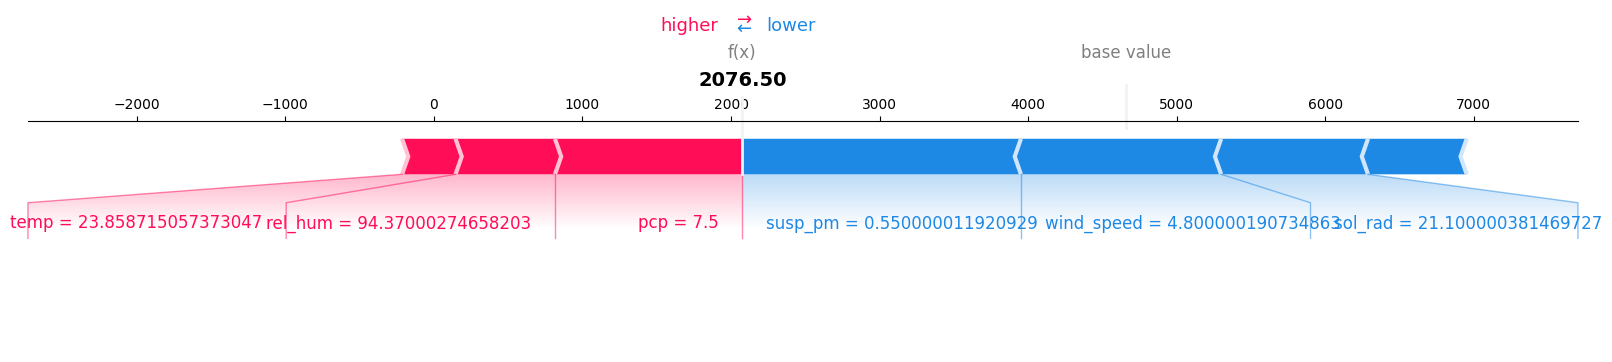

In [125]:
explainer.force_plot_single_example(30, show=True)

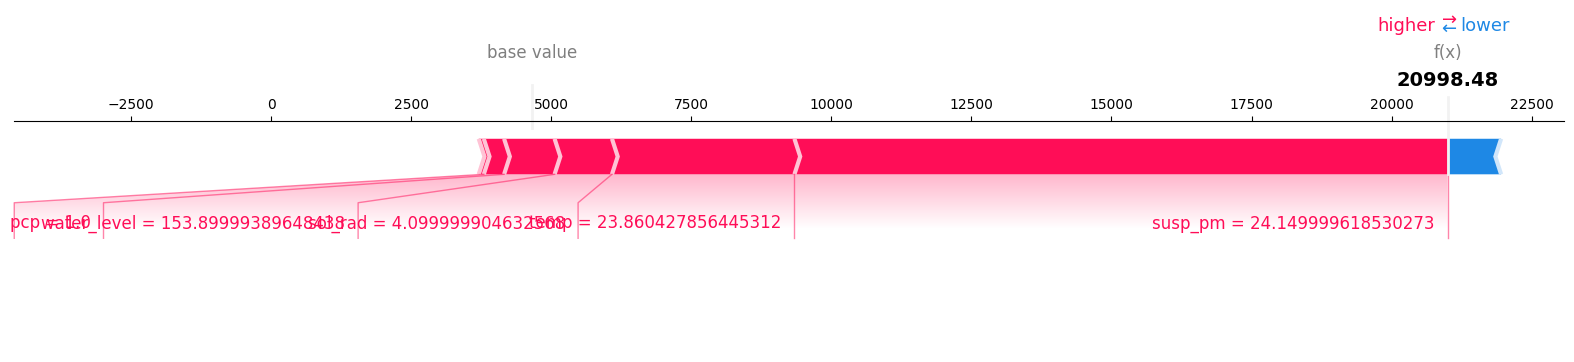

In [126]:
explainer.force_plot_single_example(31, show=True)

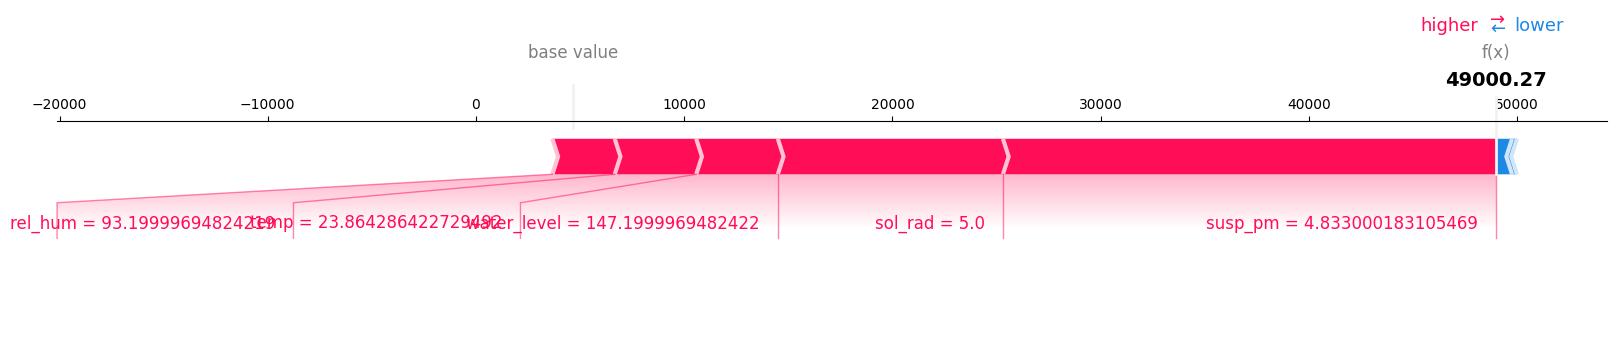

In [127]:
explainer.force_plot_single_example(32, show=True)

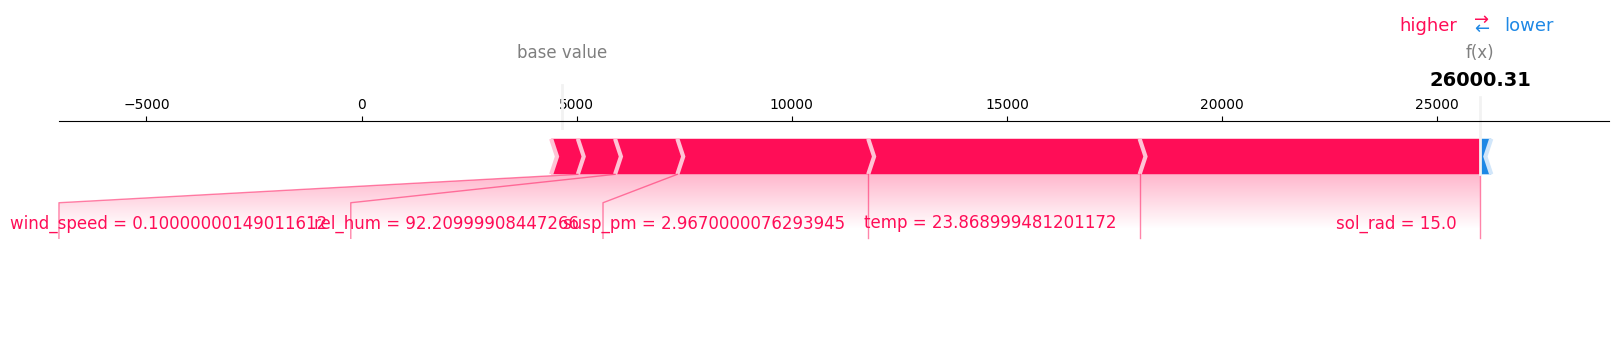

In [128]:
explainer.force_plot_single_example(33, show=True)